# Avaliação com Novos Dados e Recomendações de Fotoprotetor 

## 📝 Nota Importante sobre o Modelo Disponível

É fundamental entender que o modelo (`convnext_tiny_DS-20`) disponibilizado publicamente aqui foi treinado utilizando **apenas 20% do conjunto de dados** (`DS-20`). Seu principal objetivo é de caráter **didático**, servindo como uma prova de conceito para demonstrar a **facilidade de reprodução** do pipeline completo de avaliação e recomendação.

Este modelo foi projetado para ilustrar a metodologia e a integração das etapas, e **não para ser um modelo de produção final altamente preciso**. Embora ele consiga fazer predições, é importante ressaltar que a precisão e a robustez dos resultados seriam significativamente **melhoradas com um modelo mais eficaz**, treinado com 100% dos dados (`DS-100`) ou com conjuntos de dados maiores e mais diversos.

Portanto, os resultados obtidos com este modelo devem ser interpretados sob essa perspectiva, com foco na compreensão do processo em vez da exatidão absoluta das recomendações.

### 1. Imports e Configurações

In [ ]:
# Limpa o cache do pip
!pip cache purge

# !pip uninstall -y facenet-pytorch --q
!pip install facenet-pytorch --q

!pip install -q weasyprint

# Reinicia a sessão
import os
os.kill(os.getpid(), 9)

Files removed: 0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

<div style="color: red; border: 2px solid red; padding: 10px; background-color: #ffe6e6; border-radius: 5px;">

 ## ⚠️ AVISO IMPORTANTE: Reinicialização Necessária ⚠️

 **Para evitar quaisquer conflitos ou problemas de dependência após a instalação dos novos pacotes, o ambiente (kernel) de execução vai reinicar.**

 Após a reinicialização, por favor, prossiga e execute a célula imediatamente abaixo (e as subsequentes) para continuar o fluxo de trabalho corretamente.

 </div>

In [1]:
# Pipeline_best_MST_r05.py
# Adapted pipeline implementing:
# - Face detection (Haarcascade + MTCNN) with comparison
# - Eye-based alignment + controlled margin crop
# - RGB -> LAB conversion
# - Square resize with padding (minimal perturbation)
# - Dataset class and transforms
# - VGG16 regression model + other CNNs kept
# - Training/evaluation skeleton and model comparison


# NOTE: This script is formatted as a runnable Colab / Jupyter-friendly Python file.
# In a notebook, split into cells where appropriate.


# -----------------------------
# 1) Install / imports
# -----------------------------

import multiprocessing as mproc
mproc.set_start_method("spawn", force=True)

from google.colab import drive, files
import glob
import shutil
import os, random, math, time, sys
from pathlib import Path
from pathlib import Path
import cv2
import numpy as np
from PIL import Image, ImageOps
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import timm
from facenet_pytorch import MTCNN
import torch, PIL
import torch.multiprocessing as torch_mproc
from tqdm import tqdm
import copy
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from weasyprint import HTML
import base64
from io import BytesIO

#Isso evita travamentos com OpenCV + PyTorch em threads nativas.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"


# Configuração da GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Python version:", sys.version.splitlines()[0])
print("Torch version:", torch.__version__)
print(f"Usando dispositivo: {DEVICE}")

mtcnn = MTCNN(keep_all=False, device=DEVICE)
print(f"MTCNN inicializado com sucesso no dispositivo: {DEVICE}")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch version: 2.2.2+cu121
Usando dispositivo: cpu
MTCNN inicializado com sucesso no dispositivo: cpu


In [2]:
# ============================
# Configurações / Hiperparâmetros
# ============================
class Config:
    DATA_ROOT = "./data"
    IMG_SIZE = 224
    BATCH_SIZE = 32
    NUM_EPOCHS = 30
    LR = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_WORKERS = 0 # Alterado para 0 para depuração
    SEED = 42
    TRAIN_SIZE = 0.60
    VAL_SIZE = 0.20
    TEST_SIZE = 0.20
    OUTPUT_DIR = "./data/result"
    FP16 = True
    PATIENCE = 5
    #  options: ['front-facing', 'left-facing', 'right-facing', 'up-facing', 'down-facing']
    FASE_POS = ['front-facing']
    DATASET_PERCENT = 0.20

    def print_string_properties(self):
        print("Configurações:\n")
        for attr_name in dir(self):
            if not attr_name.startswith('__') and not callable(getattr(self, attr_name)):
                value = getattr(self, attr_name)
                # if isinstance(value, str):
                print(f"{attr_name} -> '{value}'")

        print(f"\nface position: {self.FASE_POS}")

# ============================
# Utilities
# ============================
def makedir(path):
    os.makedirs(path, exist_ok=True)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(Config.SEED)

# Otimizações de Performance
# Otimização CUDA
torch.backends.cudnn.benchmark = True  # Adicionar
torch.backends.cudnn.deterministic = False  # Para performance

"""Configura otimizações de performance"""
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

# Instantiate Config again to reflect the change
config = Config()
config.print_string_properties()

# Filenames to save
def get_filename(file_type: str, model_name: str, extensao: str | None): # Allow extensao to be None

    # --- Início da Alteração para simplificar os nomes das fases ---

    # 1. Limpa e simplifica os nomes das fases para uso em um nome de arquivo seguro:
    #    - Remove espaços, parênteses e graus, e mantém apenas as palavras.
    #    - Exemplo: 'left-facing (35°)' torna-se 'left-facing-35'.
    elementos_limpos = [
        item.replace(' ', '-').replace('(', '-').replace(')', '').replace('°', '').strip('-')
        for item in Config.FASE_POS
    ]

    # 2. Simplifica ainda mais o nome, removendo a palavra "facing" e unindo com '_'
    #    - Pega apenas o primeiro componente (ex: 'front') e o segundo (ex: 'left') se houver,
    #      e descarta os ângulos numéricos para manter a string curta.
    nomes_fases_simplificados = [
        item.split('-')[0] # Pega apenas a primeira palavra antes do hífen
        for item in elementos_limpos
    ]

    # Remove duplicatas que possam surgir se o split não funcionar bem, e une os nomes.
    fase_pos_string = '-'.join(sorted(list(set(nomes_fases_simplificados))))

    # --- Fim da Alteração ---

    base_name = f"MST_{file_type}"
    if model_name:
        base_name += f"_{model_name}"

    # Append % Dataset, face position info, e a nova string de fases simplificadas
    # Usando o novo formato: _DS-{int(100*Config.DATASET_PERCENT)}_{fase_pos_string}_IA-CG
    base_name += f'_DS-{int(100*Config.DATASET_PERCENT)}_face-{fase_pos_string}_IA-CG'

    if extensao is not None:
        return f"{base_name}.{extensao}"
    else:
        return base_name

# Teste get_filename
print()
print("Teste get_filename")
print(get_filename("model", "efficientnet_b0_Regression", "pth"))
print(get_filename("result", None, None))
print(get_filename('complete_training_history', None, 'csv'))

Configurações:

BATCH_SIZE -> '32'
DATASET_PERCENT -> '0.2'
DATA_ROOT -> './data'
FASE_POS -> '['front-facing']'
FP16 -> 'True'
IMG_SIZE -> '224'
LR -> '0.0001'
NUM_EPOCHS -> '30'
NUM_WORKERS -> '0'
OUTPUT_DIR -> './data/result'
PATIENCE -> '5'
SEED -> '42'
TEST_SIZE -> '0.2'
TRAIN_SIZE -> '0.6'
VAL_SIZE -> '0.2'
WEIGHT_DECAY -> '1e-05'

face position: ['front-facing']

Teste get_filename
MST_model_efficientnet_b0_Regression_DS-20_face-front_IA-CG.pth
MST_result_DS-20_face-front_IA-CG
MST_complete_training_history_DS-20_face-front_IA-CG.csv


## 2. Carregamento e Uso dos Modelos

### 2.1. Definições

#### 2.1.1. Dataset e Tranforms

In [5]:
# -----------------------------
# Utility functions
# -----------------------------

def pad_to_square(img: Image.Image, size: int, fill=0):
    w, h = img.size
    scale = size / max(w, h)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)
    delta_w = size - new_w
    delta_h = size - new_h # Corrected: should be delta_h = size - new_h
    pad_left = delta_w // 2
    pad_top = delta_h // 2
    pad_right = delta_w - pad_left
    pad_bottom = delta_h - pad_top
    return ImageOps.expand(img_resized, border=(pad_left, pad_top, pad_right, pad_bottom), fill=fill)

def rgb_to_lab_pil(img_pil: Image.Image):
    img = np.array(img_pil.convert('RGB'))[:, :, ::-1] # Convert to BGR for OpenCV
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    return img_lab

def calibrate_image_lab(img, ref_data):
    """Ajusta imagem com base na média e desvio padrão LAB de referência."""
    # Ensure img is in BGR format (it should be from _load_image)
    if len(img.shape) == 3 and img.shape[2] == 3:
         pass # Already BGR
    else:
         # Attempt to convert to BGR if not already
         # This might not be perfect depending on the input format, but is a safeguard
         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(img_lab)

    # Calcula estatísticas da imagem atual
    L_mean, L_std = np.mean(L), np.std(L)
    a_mean, a_std = np.mean(a), np.std(a)
    b_mean, b_std = np.mean(b), np.std(b)

    # Evita divisões por zero
    L_std = L_std if L_std > 1e-6 else 1e-6
    a_std = a_std if a_std > 1e-6 else 1e-6
    b_std = b_std if b_std > 1e-6 else 1e-6

    # Normaliza e ajusta para as médias e desvios da referência
    L_adj = ((L - L_mean) / L_std) * ref_data["std_L"] + ref_data["mean_L"]
    a_adj = ((a - a_mean) / a_std) * ref_data["std_a"] + ref_data["mean_a"]
    b_adj = ((b - b_mean) / b_std) * ref_data["std_b"] + ref_data["mean_b"]

    img_lab_adj = cv2.merge([
        np.clip(L_adj, 0, 255).astype(np.uint8),
        np.clip(a_adj, 0, 255).astype(np.uint8),
        np.clip(b_adj, 0, 255).astype(np.uint8)
    ])

    # Convert back to BGR
    img_bgr_adj = cv2.cvtColor(img_lab_adj, cv2.COLOR_LAB2BGR)
    return img_bgr_adj


# -----------------------------
# Face detection setup (Using Haar Cascade and MTCNN)
# -----------------------------

HAAR_FACE_XML = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
HAAR_EYE_XML = cv2.data.haarcascades + 'haarcascade_eye.xml' # Corrected typo here
haar_face = cv2.CascadeClassifier(HAAR_FACE_XML)
haar_eye = cv2.CascadeClassifier(HAAR_EYE_XML)

# MTCNN is initialized globally in cell 5ef1ee10

def detect_face_haar(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar_face.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    if len(faces) == 0:
        return None
    faces = sorted(faces, key=lambda r: r[2]*r[3], reverse=True)
    return faces[0] # Return the largest face

def detect_face_mtcnn(img_pil):
    """
    Detects face using MTCNN. Returns bounding box (x, y, w, h) or None.
    Assumes mtcnn is a global or accessible MTCNN instance.
    """
    try:
        # MTCNN returns boxes in (x1, y1, x2, y2) format
        boxes, _ = mtcnn.detect(img_pil)
        if boxes is not None and len(boxes) > 0:
            # Get the largest face (based on area)
            largest_box = max(boxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]))
            # Convert (x1, y1, x2, y2) to (x, y, w, h)
            x1, y1, x2, y2 = largest_box
            return (int(x1), int(y1), int(x2 - x1), int(y2 - y1))
        else:
            return None
    except Exception as e:
        print(f"Error during MTCNN detection: {e}")
        return None


def crop_face_with_margin(img_pil: Image.Image, bbox, margin_ratio=0.15):
    """
    Recorta a face com base na bounding box facial e adiciona uma margem controlada.
    Retorna uma PIL Image.
    """
    if bbox is None:
        return None # Return None if no bbox is provided

    x, y, w, h = bbox

    # Calculate center of the face
    cx = x + w // 2
    cy = y + h // 2

    # Determine the size of the square crop based on the larger dimension + margin
    crop_size = int(max(w, h) * (1 + 2 * margin_ratio)) # Increase size by margin on both sides

    # Calculate the coordinates for the square crop centered around the face center
    x1 = int(cx - crop_size // 2)
    y1 = int(cy - crop_size // 2)
    x2 = int(cx + crop_size // 2)
    y2 = int(cy + crop_size // 2)

    # Ensure the crop stays within image boundaries
    img_w, img_h = img_pil.size
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_w, x2)
    y2 = min(img_h, y2)

    # Crop the image
    crop_pil = img_pil.crop((x1, y1, x2, y2))

    return crop_pil

# -----------------------------
# Dataset class
# -----------------------------
class SkinToneDataset(Dataset):
    def __init__(self, df, img_size=224, detector='best', transform=None, calibrate=False):
        """
        df: DataFrame com colunas obrigatórias:
            - file_path: caminho completo da imagem
            - monk_tone: valor da escala MST
        detector: 'haar', 'mtcnn' ou 'best'
        calibrate: Se True, aplica calibração de cor LAB.
        """
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.detector = detector
        self.transform = transform
        self.calibrate = calibrate # Store calibrate flag

        # Declare global variables at the beginning of __init__
        global haar_face, haar_eye, HAAR_FACE_XML, HAAR_EYE_XML, _mp_face_detector, mtcnn, REFER_DATA


        # Initialize detector here if not already initialized or needed per process
        if self.detector == 'mtcnn':
             # MTCNN is initialized globally or handled by facenet_pytorch's design
             # This path should ideally not be taken if MTCNN is not used
             # Adding a check here for robustness
             if 'mtcnn' not in globals(): # Use the global mtcnn instance
                  print("Warning: MTCNN detector requested but not initialized globally. Face detection may fail.")
             pass # Using the globally initialized mtcnn_detector if it exists
        elif self.detector == 'haar':
             # Haar cascade needs to be initialized if not already
             if 'haar_face' not in globals() or 'haar_eye' not in globals():
                  HAAR_FACE_XML = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml' # Corrected typo here
                  HAAR_EYE_XML = cv2.data.haarcascades + 'haarcascade_eye.xml' # Corrected typo here
                  haar_face = cv2.CascadeClassifier(HAAR_FACE_XML)
                  haar_eye = cv2.CascadeClassifier(HAAR_EYE_XML)
        elif self.detector == 'best':
             # 'best' will try MTCNN, then Haar
             if 'mtcnn' not in globals(): # Use the global mtcnn instance
                  print("Warning: MTCNN detector requested (as part of 'best') but not initialized globally. 'best' may fallback to Haar.")
             if 'haar_face' not in globals() or 'haar_eye' not in globals():
                  HAAR_FACE_XML = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml' # Corrected typo here
                  HAAR_EYE_XML = cv2.data.haarcascades + 'haarcascade_eye.xml' # Corrected typo here
                  haar_face = cv2.CascadeClassifier(HAAR_FACE_XML)
                  haar_eye = cv2.CascadeClassifier(HAAR_EYE_XML)
        else:
             raise ValueError(f"Unknown detector: {self.detector}")

        # Check if REFER_DATA is available if calibration is requested
        if self.calibrate and 'REFER_DATA' not in globals():
            print("Warning: Calibration requested but REFER_DATA not found. Calibration will not be applied.")
            self.calibrate = False # Disable calibration if data is missing
            # You might want to raise an error or handle this more explicitly

    def __len__(self):
        return len(self.df)

    def _load_image(self, path):
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            raise FileNotFoundError(f"Imagem não encontrada ou corrompida: {path}")
        return img_bgr

    def _process_with_haar(self, img_bgr):
        face = detect_face_haar(img_bgr)
        if face is None:
            return None
        # Note: Original code had detect_eyes_haar and crop_face_with_eyes which are not defined here.
        # Using crop_face_with_margin with the face bbox for now.
        img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        crop = crop_face_with_margin(img_pil, face, margin_ratio=0.15)
        return crop # Returns PIL Image

        results = _mp_face_detector.process(img_rgb)
        if not results.detections:
            return None

        detection = results.detections[0]
        bbox = detection.location_data.relative_bounding_box
        h, w, _ = img_bgr.shape
        x = int(bbox.xmin * w)
        y = int(bbox.ymin * h)
        bw = int(bbox.width * w)
        bh = int(bbox.height * h)

        face_box = (x, y, bw, bh)
        # Note: Original code had crop_face_with_eyes which is not defined here.
        # Using crop_face_with_margin with the face bbox for now.
        img_pil = Image.fromarray(img_rgb)
        crop = crop_face_with_margin(img_pil, face_box, margin_ratio=0.15)
        return crop # Returns PIL Image

    def _process_with_mtcnn(self, img_bgr):
         """Detecção facial usando MTCNN."""
         img_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
         face_bbox = detect_face_mtcnn(img_pil)
         if face_bbox is None:
              return None
         crop = crop_face_with_margin(img_pil, face_bbox, margin_ratio=0.15)
         return crop # Returns PIL Image


    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            img_path = row['file_path']
            target = float(row['monk_tone'])
            img_bgr = self._load_image(img_path)

            chosen_pil = None
            if self.detector == 'mtcnn':
                 chosen_pil = self._process_with_mtcnn(img_bgr)
            elif self.detector == 'haar':
                chosen_pil = self._process_with_haar(img_bgr)
            elif self.detector == 'best':
                chosen_pil = self._process_with_mtcnn(img_bgr) # Try MTCNN first
                if chosen_pil is None:
                     chosen_pil = self._process_with_haar(img_bgr) # Then Haar
                if chosen_pil is None:
                     # If all fail, use the original image (converted to PIL)
                     chosen_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
            else:
                # If detector is unknown or none found, use original image
                chosen_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))


            if chosen_pil is None:
                 # If chosen_pil is still None after attempts (shouldn't happen with 'best'),
                 # use the original image as a fallback
                 chosen_pil = Image.fromarray(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

            # Convert PIL Image to BGR numpy array for calibration and further processing
            img_to_process = cv2.cvtColor(np.array(chosen_pil), cv2.COLOR_RGB2BGR)


            # Apply calibration if requested
            if self.calibrate and 'REFER_DATA' in globals():
                 img_to_process = calibrate_image_lab(img_to_process, REFER_DATA)
                 # Convert back to PIL for padding if needed, or handle padding with OpenCV
                 # For consistency with existing padding function, convert back to PIL
                 img_to_process_pil = Image.fromarray(cv2.cvtColor(img_to_process, cv2.COLOR_BGR2RGB))
            else:
                 # If not calibrating, just use the current PIL image
                 img_to_process_pil = chosen_pil


            # Pad the image
            padded = pad_to_square(img_to_process_pil, self.img_size, fill=(127, 127, 127))


            # Convert to LAB and normalize
            lab = rgb_to_lab_pil(padded).astype(np.float32)
            lab[:, :, 0] /= 100.0
            # Normalize a and b channels to [-1, 1]
            lab[:, :, 1:] = (lab[:, :, 1:] - 128.0) / 128.0
            lab = np.transpose(lab, (2, 0, 1))
            tensor = torch.from_numpy(lab)

            if self.transform:
                tensor = self.transform(tensor)

            return tensor, torch.tensor([target], dtype=torch.float32)

        except Exception as e:
            print(f"[ERRO Dataset - índice {idx}] {e}")
            dummy = torch.zeros((3, self.img_size, self.img_size), dtype=torch.float32)
            return dummy, torch.tensor([0.0], dtype=torch.float32)

# Transformações conforme artigo (somente flips)
train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
])
val_transform = T.Compose([])

print("Dataset e Tranformer pronto")

Dataset e Tranformer pronto


#### 2.1.2. Arquitetura dos Modelos

In [6]:
# -----------------------------
# Model definitions
# -----------------------------

# VGG16 regression model adapted to accept 3-channel LAB input
class VGG16Regression(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        # Keep features
        self.features = vgg.features
        # Adjust classifier to single-output regression
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Utility to adapt pretrained models expecting RGB: we will feed LAB but keep first conv
# If desired, copy weights from pretrained RGB into LAB channels average

def adapt_first_conv_rgb_to_lab(conv):
    # conv: nn.Conv2d with in_channels=3
    w = conv.weight.data
    # average weights across RGB channels -> use same for L,a,b
    w_mean = w.mean(dim=1, keepdim=True)
    new_w = w_mean.repeat(1,3,1,1)
    conv.weight.data.copy_(new_w)
    return conv

# Other models (examples) - keep same architecture but last layer adapted to regression

def get_model_by_name(name, pretrained=True):
    if name == 'vgg16':
        m = VGG16Regression(pretrained=pretrained)
        # adapt first conv if needed
        m.features[0] = adapt_first_conv_rgb_to_lab(m.features[0])
        return m
    elif name == 'efficientnet_b0':
        m = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        # change classifier
        in_f = m.classifier[1].in_features
        m.classifier = nn.Sequential(nn.Flatten(), nn.Linear(in_f, 1))
        # adapt first conv
        m.features[0][0] = adapt_first_conv_rgb_to_lab(m.features[0][0])
        return m
    elif name == 'convnext_tiny':
        m = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None)
        in_f = m.classifier[2].in_features
        m.classifier = nn.Sequential(nn.Flatten(), nn.Linear(in_f, 1))
        m.features[0][0] = adapt_first_conv_rgb_to_lab(m.features[0][0])
        return m
    elif name == 'mobilenet_v3_large':
        m = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1 if pretrained else None)
        # change classifier - the last linear layer should output 1
        # The input features to the classifier are 960 for MobileNetV3 Large
        in_f = 960 # Correct input features for the classifier
        m.classifier = nn.Sequential(
            nn.Linear(in_f, 1280), # First linear layer
            nn.Hardswish(inplace=True),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(1280, 1), # Final regression layer
        )
        m.features[0][0] = adapt_first_conv_rgb_to_lab(m.features[0][0])
        return m
    else:
        # try timm models (e.g., deit_tiny)
        m = timm.create_model(name, pretrained=pretrained, num_classes=0)
        # create head for regression
        feat_dim = m.num_features
        head = nn.Linear(feat_dim, 1)
        model = nn.Sequential(m, nn.Flatten(), head)
        return model

models_to_run = ['efficientnet_b0', 'convnext_tiny', 'mobilenet_v3_large', 'vgg16']
print("Model to Run:")
print(models_to_run)

Model to Run:
['efficientnet_b0', 'convnext_tiny', 'mobilenet_v3_large', 'vgg16']


### 2.2. Carregamento do Modelo

In [7]:
from google.colab import files
import os
import requests
import shutil # Importa o módulo shutil para remoção de diretórios

OUTPUT_DIR = Config.OUTPUT_DIR # Assumindo que Config já foi carregado
MODEL_FOLDER = os.path.join(OUTPUT_DIR, 'model')

# --- NOVO: Verifica e remove o diretório de modelos se ele já existir ---
if os.path.exists(MODEL_FOLDER):
    print(f"Diretório '{MODEL_FOLDER}' já existe. Removendo conteúdo existente...")
    shutil.rmtree(MODEL_FOLDER)
    print("Conteúdo anterior removido com sucesso.")

# Cria o diretório de modelos (será criado ou recriado)
os.makedirs(MODEL_FOLDER, exist_ok=True)

print(f"Preparando para upload de arquivos de modelo para: {MODEL_FOLDER}")

# --- Opção 1: Upload interativo do seu computador local (descomente para usar) ---
# uploaded = files.upload()
# for filename in uploaded.keys():
#     with open(os.path.join(MODEL_FOLDER, filename), 'wb') as f:
#         f.write(uploaded[filename])
#     print(f"Arquivo '{filename}' salvo em '{MODEL_FOLDER}'")
# print("Uploads concluídos!")

# --- Opção 2: Download direto de um URL (ex: GitHub raw link) ---
# Substitua este URL pelo link RAW do seu arquivo .pth no GitHub
github_raw_url = "https://github.com/celiolr/monkscale_personalized_sunscreen_notebooks/raw/refs/heads/main/data/result/model/MST_model_convnext_tiny_Regression_best_val_DS-20_face-front.pth"
# local_filename = "MST_model_convnext_tiny_Regression_best_val_DS-20_face-front.pth"  # Ou use os.path.basename()
local_filename = os.path.basename(github_raw_url)

# Verificação mais flexível para URLs do GitHub
is_github_raw = (('github.com' in github_raw_url and '/raw/' in github_raw_url) or 'raw.githubusercontent.com' in github_raw_url) and 'celiolr' in github_raw_url

if is_github_raw:
    print(f"✅ URL do GitHub detectado! Baixando...")
    try:
        response = requests.get(github_raw_url, stream=True)
        response.raise_for_status()

        file_path = os.path.join(MODEL_FOLDER, local_filename)

        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"✅ Download concluído! Arquivo salvo em: {file_path}")
        print(f"📊 Tamanho: {os.path.getsize(file_path):,} bytes")

    except requests.exceptions.RequestException as e:
        print(f"❌ Erro na requisição: {e}")
    except Exception as e:
        print(f"❌ Erro inesperado: {e}")
else:
    print("❌ URL não reconhecido como link raw do GitHub")
# ==============================================================================
# Carregamento e Detalhamento dos Modelos
# ==============================================================================
# Lista todos os arquivos .pth no diretório de modelos
print(MODEL_FOLDER)
model_files = glob.glob(os.path.join(MODEL_FOLDER, '*.pth'))

loaded_models = {}

if not model_files:
    print(f"❌ Nenhum arquivo de modelo '.pth' encontrado em '{MODEL_FOLDER}'.")
else:
    print(f"✅ Encontrados {len(model_files)} arquivos de modelo:")
    for model_path in model_files:
        print(f"- {os.path.basename(model_path)}")

        # Determina o nome base do modelo a partir do nome do arquivo
        # Isso é necessário para saber qual arquitetura de modelo instanciar.
        model_name_full = os.path.basename(model_path).replace('.pth', '')
        print(f"model_name_full = {model_name_full} e model_path = {model_path}")
        model_base_name = "Unknown_Model"
        for known_backbone in ['efficientnet_b0', 'convnext_tiny', 'mobilenet_v3_large', 'vgg16']: # Added some common timm models
             if known_backbone in model_name_full:
                 model_base_name = known_backbone
                 break

        # Verifica se o nome do modelo foi identificado para instanciar a arquitetura correta.
        if model_base_name == "Unknown_Model":
             print(f"   ❌ Não foi possível identificar a arquitetura do modelo para '{os.path.basename(model_path)}'. Pulando este arquivo.")
             continue # Pula para o próximo arquivo se o modelo for desconhecido

        # Define o short_name com base em DS-20 no nome do arquivo
        if "DS-20" in model_name_full:
            ds_tag = "DS-20"
        else:
            ds_tag = "DS-UNK"  # caso não apareça DS-20

        short_name = f"{model_base_name}_{ds_tag}"

        try:
            # PASSO 1: Criar a arquitetura do modelo VAZIA.
            # A função get_model_by_name (definida em outra célula) é usada aqui para criar a estrutura correta.
            model = get_model_by_name(model_base_name, pretrained=False) # pretrained=False é importante aqui!

            # PASSO 2: Carregar os pesos (state_dict) salvos do arquivo .pth.
            state_dict = torch.load(model_path, map_location=DEVICE)

            # Tratar prefixo 'module.' caso o modelo tenha sido salvo de um DataParallel.
            new_state_dict = {}
            for k, v in state_dict.items():
                if k.startswith('module.'):
                    new_state_dict[k[7:]] = v # Remove 'module.' prefix
                else:
                    new_state_dict[k] = v

            # Carregar os pesos limpos na arquitetura do modelo.
            model.load_state_dict(new_state_dict)
            model.to(DEVICE) # Mover o modelo para o dispositivo correto (GPU ou CPU)
            model.eval() # Colocar o modelo em modo de avaliação (importante para predição)

            # Armazenar o modelo carregado no dicionário usando o nome completo do arquivo como chave.
            # loaded_models[model_name_full] = model
            # Armazenar metadados e modelo
            loaded_models[model_name_full] = {
                "model": model,
                "short_name": short_name,
                "path": model_path
            }

            # print(f"   📖 Modelo '{model_base_name}' carregado com sucesso de '{os.path.basename(model_path)}'.")
            print(f"   📖 Modelo '{model_base_name}' ({ds_tag}) carregado com sucesso de '{os.path.basename(model_path)}'.")
        except Exception as e:
            print(f"   ❌ Erro ao carregar o modelo de '{os.path.basename(model_path)}': {e}")
            # Opcional: remover a entrada do modelo com erro se desejar
            # if model_name_full in loaded_models:
            #     del loaded_models[model_name_full]


# Verifica quantos modelos foram carregados
print(f"\nTotal de modelos carregados: {len(loaded_models)}")

# Check loaded models
print()
print("Checando os modelos carregados:")
# if loaded_models:
#     for model_key, model in loaded_models.items():
#         print(f"- Key: {model_key}")
#         print(f"  Short Name: {model['short_name']}")
#         print(f"  Type: {type(model['model'])}")
#         # You can add more checks here if needed, e.g., print a summary of the model architecture
#         # print(f"  Model summary:\n{model}\n")
# else:
#     print("Nenhum modelo carregado.")
from tabulate import tabulate

if loaded_models:
    table_data = []
    for model_key, info in loaded_models.items():
        table_data.append([
            info["short_name"],
            model_key,
            type(info["model"]).__name__
        ])

    print(tabulate(table_data, headers=[ "Short Name", "Model Key", "Model Type"], tablefmt="github"))
else:
    print("Nenhum modelo carregado.")

Preparando para upload de arquivos de modelo para: ./data/result/model
✅ URL do GitHub detectado! Baixando...
✅ Download concluído! Arquivo salvo em: ./data/result/model/MST_model_convnext_tiny_Regression_best_val_DS-20_face-front.pth
📊 Tamanho: 111,353,914 bytes
./data/result/model
✅ Encontrados 1 arquivos de modelo:
- MST_model_convnext_tiny_Regression_best_val_DS-20_face-front.pth
model_name_full = MST_model_convnext_tiny_Regression_best_val_DS-20_face-front e model_path = ./data/result/model/MST_model_convnext_tiny_Regression_best_val_DS-20_face-front.pth
   📖 Modelo 'convnext_tiny' (DS-20) carregado com sucesso de 'MST_model_convnext_tiny_Regression_best_val_DS-20_face-front.pth'.

Total de modelos carregados: 1

Checando os modelos carregados:
| Short Name          | Model Key                                                    | Model Type   |
|---------------------|--------------------------------------------------------------|--------------|
| convnext_tiny_DS-20 | MST_model_co

## 3. Predição com Novas Imagens

#### 3.1. Carregando Novos Dados, MST Swatches e Configurações

In [9]:
import os
import requests
from pathlib import Path

def download_github_folder(repo_owner, repo_name, folder_path, branch='main'):
    """
    Faz download recursivo de uma pasta do GitHub
    """
    base_url = f"https://api.github.com/repos/{repo_owner}/{repo_name}/contents/{folder_path}?ref={branch}"

    try:
        response = requests.get(base_url)
        response.raise_for_status()
        contents = response.json()

        for item in contents:
            local_path = os.path.join('/content', item['path'])
            os.makedirs(os.path.dirname(local_path), exist_ok=True)

            if item['type'] == 'file':
                print(f"📥 Baixando {item['name']} para {local_path}")
                file_response = requests.get(item['download_url'])
                with open(local_path, 'wb') as f:
                    f.write(file_response.content)
            elif item['type'] == 'dir':
                download_github_folder(repo_owner, repo_name, item['path'], branch)

    except Exception as e:
        print(f"❌ Erro: {e}")

folder_path = 'data/images'
if os.path.exists(folder_path):
    print(f"Diretório '{folder_path}' já existe. Removendo conteúdo existente...")
    shutil.rmtree(folder_path)
    print("Conteúdo anterior removido com sucesso.")

# Cria o diretório de modelos (será criado ou recriado)
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Usar a função para carregar as pessoas e o MST_Swatches
download_github_folder(
    repo_owner='celiolr',
    repo_name='monkscale_personalized_sunscreen_notebooks',
    folder_path=folder_path,
    branch='main'
)

# Carregando calibração
calibrate_file = "./data/images/calibrate_refer_data.json"
with open(calibrate_file, 'r') as f:
    REFER_DATA = json.load(f)
    print(f"REFER_DATA: {REFER_DATA}")

Diretório 'data/images' já existe. Removendo conteúdo existente...
Conteúdo anterior removido com sucesso.
📥 Baixando IMAGES.md para /content/data/images/IMAGES.md
📥 Baixando Complete MST Scale.png para /content/data/images/MST Swatches/Complete MST Scale.png
📥 Baixando Complete MST Scale_label.png para /content/data/images/MST Swatches/Complete MST Scale_label.png
📥 Baixando Complete MST Scale_vertical.png para /content/data/images/MST Swatches/Complete MST Scale_vertical.png
📥 Baixando Complete MST Scale_vertical_label.png para /content/data/images/MST Swatches/Complete MST Scale_vertical_label.png
📥 Baixando MST_1.png para /content/data/images/MST Swatches/MST_1.png
📥 Baixando MST_10.png para /content/data/images/MST Swatches/MST_10.png
📥 Baixando MST_2.png para /content/data/images/MST Swatches/MST_2.png
📥 Baixando MST_3.png para /content/data/images/MST Swatches/MST_3.png
📥 Baixando MST_4.png para /content/data/images/MST Swatches/MST_4.png
📥 Baixando MST_5.png para /content/data/

### 3.2. Preparar Dataset - Conjunto de Novos Dados

#### 3.1.1. Funções Auxiliares para Coleta de Dados

In [10]:
# --- Funções Auxiliares para Coleta de Dados ---

def collect_image_data_structured(base_dir, face_positions, person_folders=None):
    """
    Coleta dados de imagem de uma estrutura de pastas aninhada: base_dir/person*/subfolder*/image_file.
    Lê o monk_tone de um arquivo JSON na pasta da pessoa (monk_scale_value.json).
    Filtra por nomes de subpasta específicos (posições de face).

    Args:
        base_dir (str): Diretório base onde estão as pastas das pessoas.
        face_positions (list): Lista de nomes de subpastas de posição de face a incluir (e.g., ['front-facing']).
        person_folders (list, optional): Lista de nomes de diretórios de pessoas a incluir (e.g., ['pessoa001', 'pessoa002']).
                                         Se None, processa todos os diretórios 'pessoa*' em base_dir.

    Returns:
        pandas.DataFrame: DataFrame com colunas: 'Pessoa_Folder', 'Face_Position_Folder',
                          'image_name', 'file_path', 'monk_tone' (lido do JSON). Retorna DataFrame vazio em caso de erro ou sem arquivos.
    """
    print(f"\nColetando dados de estrutura aninhada em: {base_dir}")
    data = []

    if person_folders is None:
        person_dirs_paths = sorted(glob.glob(os.path.join(base_dir , 'pessoa*')))
        person_dirs_names = [os.path.basename(p) for p in person_dirs_paths]
    else:
        # Filter provided list to ensure they exist and sort
        person_dirs_paths = [os.path.join(base_dir, p) for p in person_folders if os.path.isdir(os.path.join(base_dir, p))]
        person_dirs_names = [os.path.basename(p) for p in person_dirs_paths]
        person_dirs_paths = sorted(person_dirs_paths) # Sort paths
        person_dirs_names = sorted(person_dirs_names) # Sort names


    if not person_dirs_paths:
        print(f"⚠️  Nenhum diretório de pessoa encontrado em: {base_dir}")
        return pd.DataFrame(data)

    if person_folders is None:
        print(f"✅ Processando todos os {len(person_dirs_paths)} diretórios 'pessoa*'.")
    else:
         print(f"✅ Processando {len(person_dirs_paths)} diretórios de pessoa especificados.")

    print(f"  Filtrando subpastas por: {face_positions}.")


    for person_path in tqdm(person_dirs_paths, desc="Coletando dados (estrutura aninhada)"):
        person_id = os.path.basename(person_path)
        monk_value_real = 0.0 # Valor padrão caso o JSON não seja encontrado ou lido

        # --- Tentar ler o monk_tone real do arquivo JSON na pasta da pessoa ---
        json_file_path = os.path.join(person_path, 'monk_scale_value.json')
        if os.path.exists(json_file_path):
            try:
                with open(json_file_path, 'r') as f:
                    monk_data = json.load(f)
                    if isinstance(monk_data, dict) and 'value' in monk_data:
                        monk_value_real = float(monk_data['value'])
                        # print(f"  Debug: Lido monk_tone {monk_value_real} para {person_id}") # Debug print
                    else:
                        print(f"Warning: Arquivo JSON '{json_file_path}' não tem formato esperado (missing 'value' key). Usando valor padrão 0.0.")
            except json.JSONDecodeError:
                print(f"Warning: Não foi possível decodificar o arquivo JSON '{json_file_path}'. Usando valor padrão 0.0.")
            except Exception as e:
                print(f"Warning: Erro inesperado ao ler JSON '{json_file_path}': {e}. Usando valor padrão 0.0.")
        else:
            # print(f"Warning: Arquivo JSON '{json_file_path}' não encontrado para {person_id}. Usando valor padrão 0.0.") # Keep silent for less verbosity
            pass # Arquivo JSON não encontrado, usa valor padrão 0.0

        # --- Continuar coletando dados das imagens na subpasta ---
        try: # Adiciona try-except para processamento de subpastas dentro de cada pessoa
            # List items and filter for directories and face positions
            items_in_person_dir = os.listdir(person_path)
            subfolders_to_process = [item_name for item_name in items_in_person_dir
                                     if os.path.isdir(os.path.join(person_path, item_name)) and item_name in face_positions]

            for item_name in subfolders_to_process:
                item_path = os.path.join(person_path, item_name)

                # Busca por arquivos .jpg, .png e .jpeg dentro da subpasta de posição
                for image_name in os.listdir(item_path):
                    if image_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                        file_full_path = os.path.join(item_path, image_name)
                        if os.path.exists(file_full_path): # Verifica se o arquivo realmente existe
                            data.append({
                                'Pessoa_Folder': person_id,
                                'Face_Position_Folder': item_name, # O nome da subpasta é a posição
                                'image_name': image_name,
                                'file_path': file_full_path,
                                'monk_tone': monk_value_real, # Usar o valor lido do JSON aqui
                                # 'monk_tone_pred': 0.0 # Valor a ser predito
                            })
                        else:
                            print(f"Warning: Arquivo esperado não encontrado no disco: {file_full_path}. Pulando.")


        except Exception as e:
             print(f"❌ ERRO ao processar subpastas para Pessoa '{person_id}': {e}. Continuando com a próxima pessoa.")

    print(f"✅ Coleta de dados de estrutura aninhada concluída. Total de arquivos encontrados: {len(data)}.")
    return pd.DataFrame(data)


def collect_image_data_flat(base_dir):
    """
    Coleta dados de imagem de uma estrutura de pasta plana: base_dir/image_file.

    Args:
        base_dir (str): Diretório onde os arquivos de imagem estão diretamente.

    Returns:
        pandas.DataFrame: DataFrame com colunas: 'image_name', 'file_path',
                          'monk_tone' (dummy=0.0). Retorna DataFrame vazio em caso de erro ou sem arquivos.
    """
    print(f"\nColetando dados de estrutura plana em: {base_dir}")
    data = []
    if not os.path.exists(base_dir):
         print(f"⚠️  Diretório '{base_dir}' não encontrado.")
         return pd.DataFrame(data)

    try: # Adiciona try-except para processamento do diretório
        for item_name in os.listdir(base_dir):
            # Adiciona verificação para pular pastas de sistema irrelevantes
            if item_name == '.ipynb_checkpoints' or item_name.startswith('__'):
                 # print(f"Pulando item irrelevante: {os.path.join(base_dir, item_name)}") # Keep silent
                 continue

            item_path = os.path.join(base_dir, item_name)

            if os.path.isfile(item_path) and item_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                # monk_tone pode ser extraído do nome do arquivo ou de um label file se disponível
                # Para calibração apenas, um valor dummy 0.0 é suficiente se não houver labels
                monk_label_cal = 0.0 # Valor dummy ou extrair label real se disponível/necessário

                if os.path.exists(item_path): # Verifica se o arquivo realmente existe
                    data.append({
                        'image_name': item_name,
                        'file_path': item_path,
                        'monk_tone': float(monk_label_cal)
                    })
                else:
                    print(f"Warning: Arquivo esperado não encontrado no disco: {item_path}. Pulando.")

            # elif os.path.isdir(item_path): # Optional: warn about other directories being skipped
                 # print(f"Warning: Skipping directory '{item_name}' in calibration directory as it's not an image file.") # Keep silent

    except Exception as e:
         print(f"❌ ERRO ao processar diretório '{base_dir}': {e}.")

    print(f"\n✅ Coleta de dados de estrutura plana concluída. Total de arquivos encontrados: {len(data)}.")
    return pd.DataFrame(data)

print("✅ Funções de Coleta de Dados prontas.")

✅ Funções de Coleta de Dados prontas.


#### 3.2.1. Novos Dados

In [11]:
print("\n--- Coletando novos dados e criando DataFrames usando funções auxiliares ---")

# Define se quer usar uma lista específica de pessoas ou todas
LOCAL_IMAGE_DIR = '/content/data/images/pessoas'
use_specific_persons = False # Mude para True para usar a lista abaixo, False para usar todas

# Lista de pessoas específicas (usada se use_specific_persons for True)
specific_person_folders=['pessoa001', 'pessoa002']

if use_specific_persons:
    person_folders_to_process = specific_person_folders
    print(f"Usando lista específica de pessoas: {person_folders_to_process}")
else:
    # Coleta todas as subpastas que começam com 'pessoa' no LOCAL_IMAGE_DIR
    all_person_folders = [name for name in os.listdir(LOCAL_IMAGE_DIR) if os.path.isdir(os.path.join(LOCAL_IMAGE_DIR, name)) and name.startswith('pessoa')]
    person_folders_to_process = sorted(all_person_folders)
    print(f"Processando todas as pessoas encontradas: {person_folders_to_process}")

print(person_folders_to_process)

# Coletar dados para o conjunto de TESTE (estrutura aninhada)
# Usaremos as posições de face definidas em Config.FASE_POS para filtrar as subpastas.
new_data_df = collect_image_data_structured(LOCAL_IMAGE_DIR, Config.FASE_POS, person_folders=person_folders_to_process)

print(f"\nQuantidade de imagens no conjunto de novos dados para processar (new_data_df): {len(new_data_df)}.")
print("\nPrimeiras linhas do DataFrame de Teste:")
display(new_data_df)


--- Coletando novos dados e criando DataFrames usando funções auxiliares ---
Processando todas as pessoas encontradas: ['pessoa001', 'pessoa002', 'pessoa003', 'pessoa004']
['pessoa001', 'pessoa002', 'pessoa003', 'pessoa004']

Coletando dados de estrutura aninhada em: /content/data/images/pessoas
✅ Processando 4 diretórios de pessoa especificados.
  Filtrando subpastas por: ['front-facing'].


Coletando dados (estrutura aninhada): 100%|██████████| 4/4 [00:00<00:00, 2217.74it/s]

✅ Coleta de dados de estrutura aninhada concluída. Total de arquivos encontrados: 8.

Quantidade de imagens no conjunto de novos dados para processar (new_data_df): 8.

Primeiras linhas do DataFrame de Teste:


,Pessoa_Folder,Face_Position_Folder,image_name,file_path,monk_tone
0,pessoa001,front-facing,139b.jpg,/content/data/images/pessoas/pessoa001/front-f...,0.0
1,pessoa001,front-facing,139a.jpg,/content/data/images/pessoas/pessoa001/front-f...,0.0
2,pessoa002,front-facing,142a.jpg,/content/data/images/pessoas/pessoa002/front-f...,0.0
3,pessoa002,front-facing,142b.jpg,/content/data/images/pessoas/pessoa002/front-f...,0.0
4,pessoa003,front-facing,147a.jpg,/content/data/images/pessoas/pessoa003/front-f...,0.0
5,pessoa003,front-facing,147b.jpg,/content/data/images/pessoas/pessoa003/front-f...,0.0
6,pessoa004,front-facing,157b.jpg,/content/data/images/pessoas/pessoa004/front-f...,0.0
7,pessoa004,front-facing,157a.jpg,/content/data/images/pessoas/pessoa004/front-f...,0.0


#### 3.2.3. Preparação dos Dataset / Loaders

In [12]:
# Create DataLoader for prediction
prediction_ds_new = SkinToneDataset(
    df=new_data_df,
    img_size=Config.IMG_SIZE,
    detector='mtcnn', # Or 'best', 'haar', 'mediapipe'
    transform=val_transform,  # val_transform
    calibrate=False
)
prediction_loader_new = DataLoader(
    prediction_ds_new,
    batch_size=Config.BATCH_SIZE, # Use a larger batch size for inference if memory allows
    shuffle=False,
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False,
)

print(f"✅ DataLoader para predição do conjunto de novos dados criado com {len(prediction_loader_new)} batches.")

prediction_ds_new_calibrated = SkinToneDataset(
    df=new_data_df,
    img_size=Config.IMG_SIZE,
    detector='mtcnn', # Or 'best', 'haar', 'mediapipe'
    transform=val_transform,  # val_transform
    calibrate=True
)
prediction_loader_new_calibrated = DataLoader(
    prediction_ds_new_calibrated,
    batch_size=Config.BATCH_SIZE, # Use a larger batch size for inference if memory allows
    shuffle=False,
    num_workers=0,
    pin_memory=True if DEVICE.type == 'cuda' else False,
)

print(f"✅ DataLoader para predição do conjunto de novos dados calibrados criado com {len(prediction_loader_new_calibrated)} batches.")

✅ DataLoader para predição do conjunto de novos dados criado com 1 batches.
✅ DataLoader para predição do conjunto de novos dados calibrados criado com 1 batches.


### 3.3. Predição com Novos Dados

#### 3.3.1. Funções Auxiliares

In [13]:
from tqdm.notebook import tqdm # Ensure tqdm is imported if not already

def add_model_predictions_from_loader_as_columns(dataloader, df, loaded_models, config, device):
    print(f"Iniciando predições a partir do DataLoader para {len(df)} imagens...")

    if not loaded_models or dataloader is None or df is None or df.empty:
        print("❌ Entradas inválidas. Abortando.")
        return df

    output_df = df.copy()
    model_predictions = {key: [] for key in loaded_models.keys()}

    # Mover todos os modelos para GPU e modo eval antes do loop
    for model_info in loaded_models.values():
        model_info['model'].to(device)
        model_info['model'].eval()

    # Loop principal por batch com tqdm para barra de progresso
    # Using dataloader.dataset to get the total length for tqdm if dataloader doesn't have __len__ directly
    # Or simpler, just use total=len(dataloader) if dataloader provides length
    # If dataloader is from torch.utils.data.DataLoader, len(dataloader) works.
    for images, targets in tqdm(dataloader, desc="Processando batches para predição"):
        if images is None or images.shape[0] == 0:
            continue
        images = images.to(device, non_blocking=True)

        with torch.inference_mode(), torch.cuda.amp.autocast():
            for model_key, model_info in loaded_models.items():
                preds = model_info['model'](images)
                model_predictions[model_key].extend(preds.squeeze().cpu().tolist())

    # Adiciona colunas
    for model_key, preds in model_predictions.items():
        short_name = loaded_models[model_key]['short_name']
        if len(preds) == len(output_df):
            output_df[short_name] = preds
        else:
            print(f"⚠️ Predições ({len(preds)}) ≠ linhas ({len(output_df)}). Ignorando {short_name}")

    print("✅ Predição concluída.")
    return output_df

print("✅ Funções auxiliares prontas")

✅ Funções auxiliares prontas


#### 3.3.2. Predição

In [14]:
from tqdm.notebook import tqdm # Import the notebook version of tqdm

if 'prediction_loader_new' in globals() and prediction_loader_new is not None and 'new_data_df' in globals() \
          and new_data_df is not None and not new_data_df.empty:
    print("\nProcessando prediction_loader_new e new_data_df ...")
    try:
        new_df_with_preds_from_loader = add_model_predictions_from_loader_as_columns(
            dataloader=prediction_loader_new, # Passa o DataLoader SEM calibração
            df=new_data_df, # Passa o DataFrame associado
            loaded_models=loaded_models,
            config=Config,
            device=DEVICE
        )
        display(new_df_with_preds_from_loader)
    except Exception as e:
         print(f"❌ ERRO ao processar prediction_loader_new (Normal): {e}")
else:
     print("\n⚠️  DataLoader 'prediction_loader_new' ou DataFrame 'new_data_df' associado não encontrados/vazios para o cenário Calibrado.")


new_data_df_calibrated = new_data_df.copy()
if 'prediction_ds_new_calibrated' in globals() and prediction_ds_new_calibrated is not None and 'prediction_ds_new_calibrated' in globals() \
            and prediction_ds_new_calibrated is not None and hasattr(prediction_ds_new_calibrated, 'df') and not prediction_ds_new_calibrated.df.empty:
     print("\nProcessando prediction_ds_new_calibrated e new_data_df_calibrated...")
     try:
         new_calibrated_df_with_preds_from_loader = add_model_predictions_from_loader_as_columns(
             dataloader=prediction_loader_new_calibrated, # Passa o DataLoader COM calibração (o último atribuído a prediction_loader_new)
             df=prediction_ds_new_calibrated.df, # Passa o DataFrame associado (do objeto Dataset calibrado)
             loaded_models=loaded_models,
             config=Config,
             device=DEVICE
         )
         display(new_calibrated_df_with_preds_from_loader)
     except Exception as e:
        print(f"❌ ERRO ao processar prediction_ds_new_calibrated (Calibrado): {e}")
else:
     print("\n⚠️  DataLoader 'prediction_ds_new_calibrated' ou DataFrame 'prediction_ds_new_calibrated' associado não encontrados/vazios para o cenário Calibrado.")


print("\nFim do exemplo de uso da função add_model_predictions_from_loader_as_columns.")


Processando prediction_loader_new e new_data_df ...
Iniciando predições a partir do DataLoader para 8 imagens...


Processando batches para predição:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


✅ Predição concluída.


,Pessoa_Folder,Face_Position_Folder,image_name,file_path,monk_tone,convnext_tiny_DS-20
0,pessoa001,front-facing,139b.jpg,/content/data/images/pessoas/pessoa001/front-f...,0.0,5.026052
1,pessoa001,front-facing,139a.jpg,/content/data/images/pessoas/pessoa001/front-f...,0.0,5.015925
2,pessoa002,front-facing,142a.jpg,/content/data/images/pessoas/pessoa002/front-f...,0.0,5.012718
3,pessoa002,front-facing,142b.jpg,/content/data/images/pessoas/pessoa002/front-f...,0.0,5.014829
4,pessoa003,front-facing,147a.jpg,/content/data/images/pessoas/pessoa003/front-f...,0.0,5.016864
5,pessoa003,front-facing,147b.jpg,/content/data/images/pessoas/pessoa003/front-f...,0.0,5.028524
6,pessoa004,front-facing,157b.jpg,/content/data/images/pessoas/pessoa004/front-f...,0.0,5.036448
7,pessoa004,front-facing,157a.jpg,/content/data/images/pessoas/pessoa004/front-f...,0.0,5.019881



Processando prediction_ds_new_calibrated e new_data_df_calibrated...
Iniciando predições a partir do DataLoader para 8 imagens...


Processando batches para predição:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


✅ Predição concluída.


,Pessoa_Folder,Face_Position_Folder,image_name,file_path,monk_tone,convnext_tiny_DS-20
0,pessoa001,front-facing,139b.jpg,/content/data/images/pessoas/pessoa001/front-f...,0.0,5.009967
1,pessoa001,front-facing,139a.jpg,/content/data/images/pessoas/pessoa001/front-f...,0.0,5.010986
2,pessoa002,front-facing,142a.jpg,/content/data/images/pessoas/pessoa002/front-f...,0.0,5.011689
3,pessoa002,front-facing,142b.jpg,/content/data/images/pessoas/pessoa002/front-f...,0.0,5.016219
4,pessoa003,front-facing,147a.jpg,/content/data/images/pessoas/pessoa003/front-f...,0.0,5.009284
5,pessoa003,front-facing,147b.jpg,/content/data/images/pessoas/pessoa003/front-f...,0.0,5.013968
6,pessoa004,front-facing,157b.jpg,/content/data/images/pessoas/pessoa004/front-f...,0.0,5.017788
7,pessoa004,front-facing,157a.jpg,/content/data/images/pessoas/pessoa004/front-f...,0.0,5.012012



Fim do exemplo de uso da função add_model_predictions_from_loader_as_columns.


##### 3.3.2.1 Salvar Dataframe

In [15]:
import os

# Define the output directory from Config
output_dir = Config.OUTPUT_DIR
makedir(output_dir) # Ensure the output directory exists

# Get the model key from loaded_models (assuming there's at least one model loaded)
if loaded_models:
    # Get the first model key as a base for the filename
    model_key = list(loaded_models.keys())[0]
    # Get the short name for a more concise filename
    short_model_name = loaded_models[model_key]['short_name']
    # Create a filename based on the DataFrame content and model name
    filename = f"predictions_calibrated_{short_model_name}.csv"
else:
    # Fallback filename if no models are loaded
    filename = "predictions_calibrated.csv"
    print("Warning: No models loaded, using a generic filename for the CSV.")


output_path = os.path.join(output_dir, filename)

try:
    new_calibrated_df_with_preds_from_loader.to_csv(output_path, index=False)
    print(f"✅ DataFrame salvo com sucesso em: {output_path}")
except Exception as e:
    print(f"❌ Erro ao salvar o DataFrame em CSV: {e}")

✅ DataFrame salvo com sucesso em: ./data/result/predictions_calibrated_convnext_tiny_DS-20.csv


#### 3.2.3. Visualização de Amostras do Dataset

🚀 Iniciando análise dos datasets...

Visualizando amostra(s) para 4 pessoa(s) aleatória(s) do dataset 'Novas calibradas'...

Dataset: Novas calibradas | Pessoa: pessoa001 | Posição: front-facing | 2 imagens
Face detectada para histograma: (302, 260, 3)
Face detectada para histograma: (300, 260, 3)


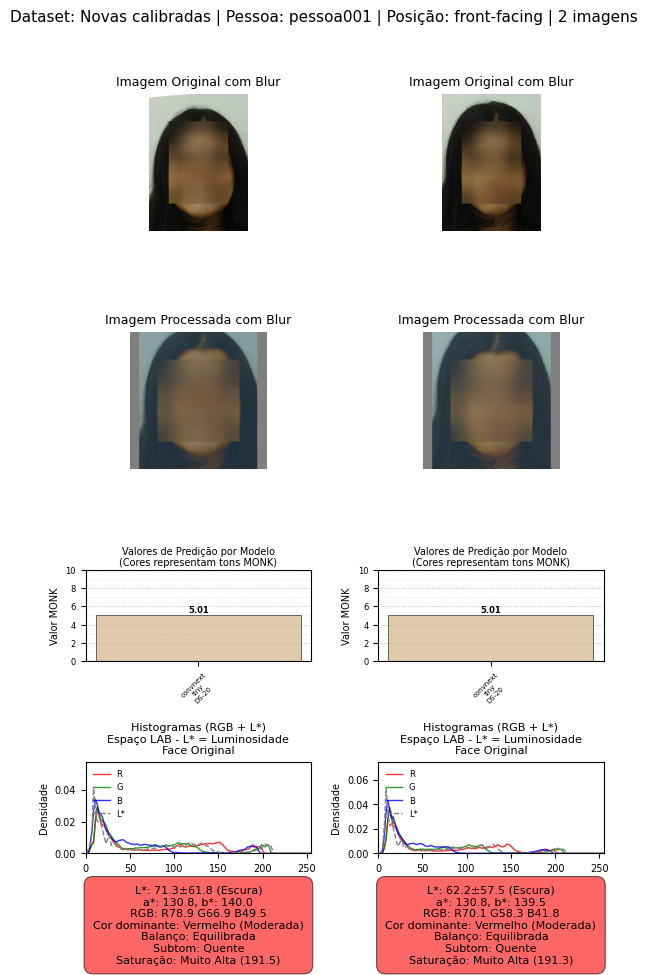


Dataset: Novas calibradas | Pessoa: pessoa004 | Posição: front-facing | 2 imagens
Face detectada para histograma: (318, 260, 3)
Face detectada para histograma: (328, 260, 3)


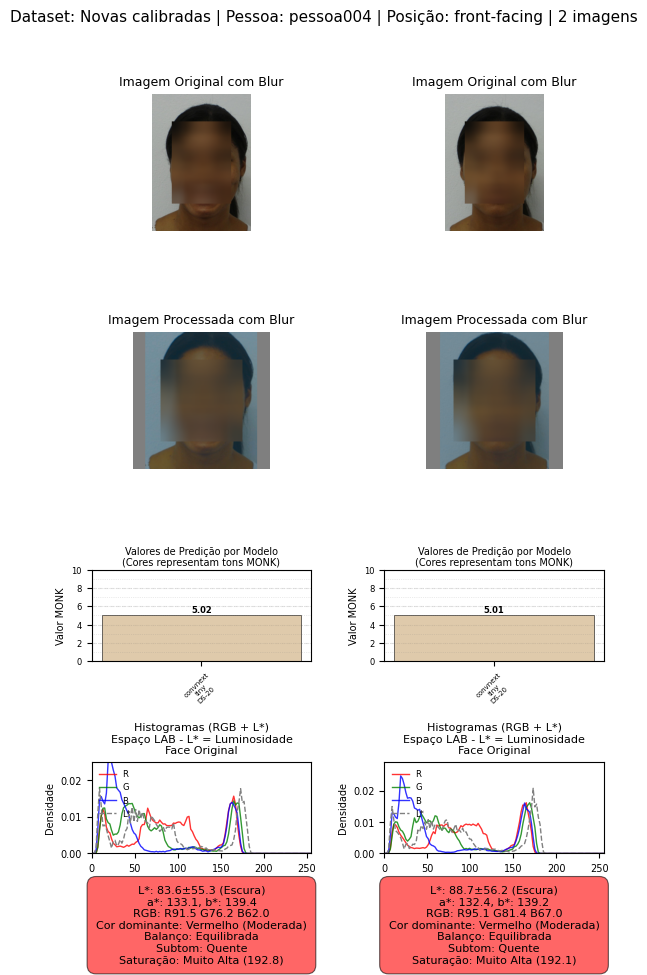


Dataset: Novas calibradas | Pessoa: pessoa002 | Posição: front-facing | 2 imagens
Face detectada para histograma: (310, 260, 3)
Face detectada para histograma: (314, 260, 3)


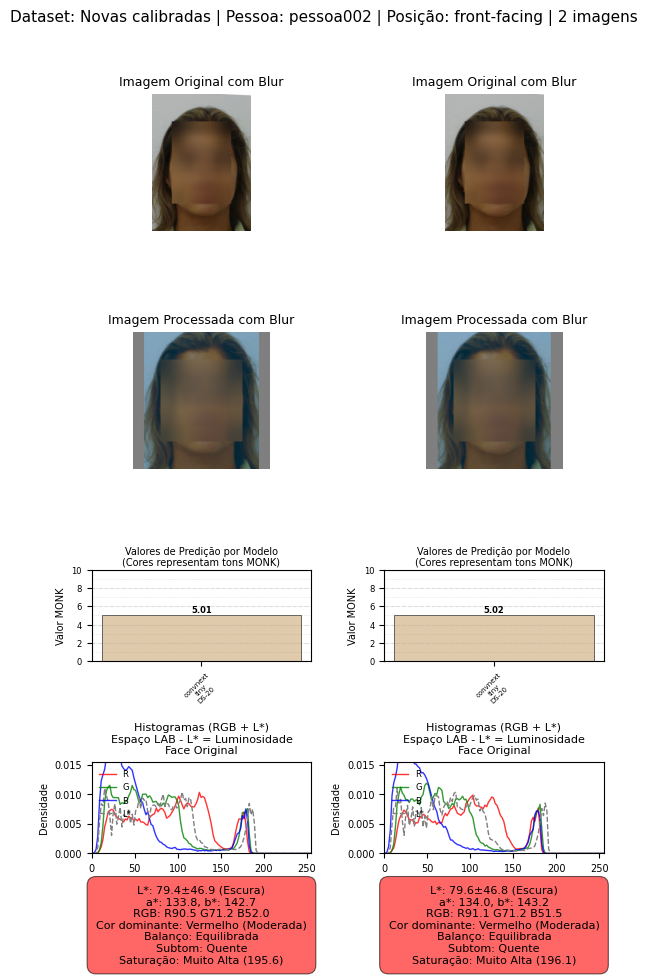


Dataset: Novas calibradas | Pessoa: pessoa003 | Posição: front-facing | 2 imagens
Face detectada para histograma: (316, 260, 3)
Face detectada para histograma: (320, 260, 3)


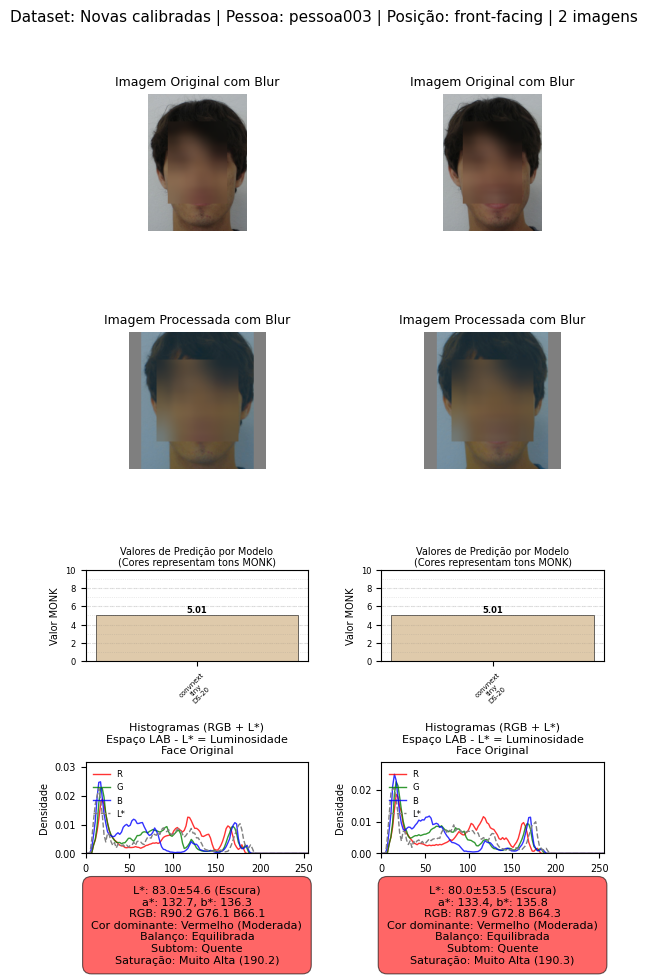


📊 Gerando PDF com 4 figuras...
✅ PDF gerado com sucesso: monk_relatorio_amostras_v01b.pdf (1109.5 KB)
📅 Data/hora de geração: 19/11/2025 11:24:45



📎 Alternativas de download:


/content/monk_relatorio_amostras_v01b.pdf

In [16]:
import re
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import os
import random
import pandas as pd

# ===== NOVO: Adicionar suporte a PDF =====
from weasyprint import HTML
import base64
from io import BytesIO
from IPython.display import display
from datetime import datetime

# No início do seu código, adicione:
import logging
import sys

# Configurar logging para ser mais silencioso
logging.basicConfig(level=logging.WARNING, stream=sys.stdout)

# Ou desativar completamente:
logging.disable(logging.CRITICAL)

# Lista global para armazenar todas as figuras
todas_as_figuras = []
# =========================================

# Monk colors definition
monk_colors = [
    ("Monk 01", "#F6EDE4"),
    ("Monk 02", "#F3E7DB"),
    ("Monk 03", "#F7EAD0"),
    ("Monk 04", "#EADABA"),
    ("Monk 05", "#D7BD96"),
    ("Monk 06", "#A07E56"),
    ("Monk 07", "#825C43"),
    ("Monk 08", "#604134"),
    ("Monk 09", "#3A312A"),
    ("Monk 10", "#292420"),
]
monk_hex_colors = [color for name, color in monk_colors]

# Function to get color based on prediction value
def get_monk_color(prediction):
    clamped_prediction = max(1.0, min(10.0, prediction))
    if clamped_prediction == 10.0:
        index = 9
    else:
        index = int(np.floor(clamped_prediction)) - 1
        index = max(0, min(9, index))
    return monk_hex_colors[index]

# Helper function to add value labels on bars
def autolabel_horizontal(rects, ax):
    for rect in rects:
        width = rect.get_width()
        if 0 <= width <= 11:
            ax.annotate(f'{width:.2f}',
                        xy=(width, rect.get_y() + rect.get_height()/2),
                        xytext=(3, 0),
                        textcoords="offset points",
                        ha='left', va='center', fontsize=7)

# def apply_blurring_mask(image, bbox, kernel_size_ratio=0.25, blur_passes=2, is_debug=False):
#     if bbox is None:
#         return image
#     if image.dtype != np.uint8:
#         img = np.clip(image * 255, 0, 255).astype(np.uint8)
#     else:
#         img = image.copy()

#     x, y, w, h = bbox
#     img_h, img_w = img.shape[:2]

#     # Versão simplificada e mais rápida
#     x1, y1 = max(0, x), max(0, y)
#     x2, y2 = min(img_w, x + w), min(img_h, y + h) # Corrected: min(img_h, y + h)
#     if x1 >= x2 or y1 >= y2:
#         return image

#     # Kernel size fixo para velocidade
#     face_width = x2 - x1
#     kernel_size = max(71, int(face_width * 0.15))
#     kernel_size = kernel_size + 1 if kernel_size % 2 == 0 else kernel_size

#     # Aplicar blur apenas uma vez
#     face_roi = img[y1:y2, x1:x2]
#     blurred_face = cv2.GaussianBlur(face_roi, (kernel_size, kernel_size), 0)
#     img[y1:y2, x1:x2] = blurred_face
#     return img


# A função abaixo é bem mais rápida, mas o blur na face recortada não é tão privativo
# def apply_blurring_mask(image, bbox, kernel_size_ratio=0.15, blur_passes=1,
#                         target_width=96, use_box_blur=True, is_debug=False):
#     if bbox is None:
#         return image

#     x, y, w, h = bbox
#     img_h, img_w = image.shape[:2]
#     x1, y1 = max(0, x), max(0, y)
#     x2, y2 = min(img_w, x + w), min(img_h, y + h)
#     if x1 >= x2 or y1 >= y2:
#         return image

#     # Somente a ROI será convertida/blurred
#     roi = image[y1:y2, x1:x2]
#     orig_dtype = image.dtype
#     is_float = np.issubdtype(orig_dtype, np.floating)

#     # trabalhar em uint8 para eficiência do OpenCV
#     if is_float:
#         roi_uint8 = np.clip(roi * 255.0, 0, 255).astype(np.uint8)
#     else:
#         roi_uint8 = roi.copy()

#     face_w = roi_uint8.shape[1]
#     face_h = roi_uint8.shape[0]

#     # Se a face for pequena, não downscale; caso contrário, reduz para target_width
#     scale = 1.0
#     if face_w > target_width:
#         scale = face_w / float(target_width)
#     small_w = max(1, int(round(face_w / scale)))
#     small_h = max(1, int(round(face_h / scale)))
#     small = cv2.resize(roi_uint8, (small_w, small_h), interpolation=cv2.INTER_LINEAR)

#     # kernel relativo ao tamanho reduzido
#     k = max(3, int(round(small_w * kernel_size_ratio)))
#     if k % 2 == 0:
#         k += 1

#     # aplicando blur (múltiplas passadas se necessário)
#     blurred_small = small
#     for _ in range(max(1, blur_passes)):
#         if use_box_blur:
#             # box blur costuma ser mais rápido para kernels grandes
#             blurred_small = cv2.blur(blurred_small, (k, k))
#         else:
#             blurred_small = cv2.GaussianBlur(blurred_small, (k, k), 0)

#     # reescala para o tamanho original da ROI e cola de volta
#     blurred_roi_uint8 = cv2.resize(blurred_small, (face_w, face_h), interpolation=cv2.INTER_LINEAR)

#     out = image.copy()
#     if is_float:
#         blurred_roi = blurred_roi_uint8.astype(np.float32) / 255.0
#         # se imagem float tiver canais diferentes, garante tipos compatíveis
#         out[y1:y2, x1:x2] = blurred_roi.astype(orig_dtype)
#     else:
#         out[y1:y2, x1:x2] = blurred_roi_uint8

#     if is_debug:
#         print(f"ROI ({face_w}x{face_h}) -> small ({small_w}x{small_h}), kernel={k}, passes={blur_passes}")

#     return out

# python
import numpy as np
import cv2

def apply_blurring_mask(image, bbox,
                        kernel_size_ratio=0.15,
                        blur_passes=1,
                        face_only_threshold=0.6,
                        face_only_target_width=24,
                        target_width=96,
                        use_box_blur=True,
                        min_kernel=3,
                        is_debug=False):
    """
    Aplica blur na bbox. Se bbox ocupar grande parte da imagem (foto só do rosto),
    usa downscale mais agressivo (`face_only_target_width`) para aumentar o blur
    de forma rápida.
    """
    if bbox is None:
        return image

    x, y, w, h = bbox
    img_h, img_w = image.shape[:2]

    # converte para uint8 para operar com OpenCV de forma eficiente
    orig_dtype = image.dtype
    is_float = np.issubdtype(orig_dtype, np.floating)
    if is_float:
        img = np.clip(image * 255.0, 0, 255).astype(np.uint8)
    else:
        img = image.copy()

    x1, y1 = max(0, x), max(0, y)
    x2, y2 = min(img_w, x + w), min(img_h, y + h)
    if x1 >= x2 or y1 >= y2:
        return image

    face_w = x2 - x1
    face_h = y2 - y1

    # detectar se a imagem é provavelmente um crop do rosto
    width_ratio = face_w / float(img_w)
    height_ratio = face_h / float(img_h)
    is_face_only = max(width_ratio, height_ratio) >= face_only_threshold

    # escolhe target width: agressivo se face-only, senão padrão
    effective_target = face_only_target_width if is_face_only else target_width

    # calcula escala para reduzir a ROI rapidamente
    scale = 1.0
    if face_w > effective_target:
        scale = face_w / float(effective_target)
    small_w = max(1, int(round(face_w / scale)))
    small_h = max(1, int(round(face_h / scale)))

    if is_debug:
        print(f"is_face_only={is_face_only}, face=({face_w}x{face_h}), img=({img_w}x{img_h}), small=({small_w}x{small_h}), target={effective_target}")

    # corta e downscale usando INTER_AREA (bom para redução)
    face_roi = img[y1:y2, x1:x2]
    small = cv2.resize(face_roi, (small_w, small_h), interpolation=cv2.INTER_AREA)

    # kernel relativo ao tamanho reduzido (garante impar e >= min_kernel)
    k = max(min_kernel, int(round(small_w * kernel_size_ratio)))
    if k % 2 == 0:
        k += 1

    # aplica blur na versão reduzida (mais rápido)
    blurred_small = small
    for _ in range(max(1, blur_passes)):
        if use_box_blur:
            # box blur é muito rápido e gera desfoque suave quando combinado com down/upscale
            blurred_small = cv2.blur(blurred_small, (k, k))
        else:
            blurred_small = cv2.GaussianBlur(blurred_small, (k, k), 0)

    # reescala para o tamanho original da ROI
    blurred_roi_u8 = cv2.resize(blurred_small, (face_w, face_h), interpolation=cv2.INTER_LINEAR)

    out = img.copy()
    out[y1:y2, x1:x2] = blurred_roi_u8

    # restaura o dtype original
    if is_float:
        return (out.astype(np.float32) / 255.0).astype(orig_dtype)
    return out


def plot_rgb_lstar_histogram_ax(image_rgb, ax, title_suffix="", plot_text=True):
    if image_rgb is None:
        return ax

    colors = {"R": "red", "G": "green", "B": "blue"}

    # MODIFICADO: Usar plot em vez de hist para mostrar apenas as linhas
    for i, col in enumerate(["R", "G", "B"]):
        # Calcular histograma sem plotar
        hist_rgb, bins_rgb = np.histogram(image_rgb[:, :, i].ravel(), bins=128, range=(0, 256), density=True)
        bins_center_rgb = (bins_rgb[:-1] + bins_rgb[1:]) / 2.0

        # Plotar apenas a linha (sem área preenchida)
        ax.plot(bins_center_rgb, hist_rgb, color=colors[col], alpha=0.8, linewidth=1.0, label=col)

    # Calcular L* de forma mais eficiente
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    L, a, b = cv2.split(lab)
    L = L.astype(np.float32)
    a = a.astype(np.float32)
    b = b.astype(np.float32)

    hist_L, bins = np.histogram(L.ravel(), bins=128, range=(0, 256), density=True)
    bins_center = (bins[:-1] + bins[1:]) / 2.0

    ax.plot(bins_center, hist_L, color='gray', linewidth=1.0, linestyle='--', label='L*')

    ax.set_xlim([0, 255])

    # Título principal e subtítulo
    ax.set_title(f"Histogramas (RGB + L*)\nEspaço LAB - L* = Luminosidade\n{title_suffix}", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.yaxis.tick_left()
    ax.legend(fontsize=6, frameon=False, loc='upper left')

    # Análise e interpretação dos dados
    stats_text = ""

    # Calcular estatísticas RGB
    rgb_mean = [np.mean(image_rgb[:, :, i]) for i in range(3)]
    rgb_std = [np.std(image_rgb[:, :, i]) for i in range(3)]

    # Calcular estatísticas L*
    L_mean = np.mean(L)
    L_std = np.std(L)
    a_mean = np.mean(a)
    b_mean = np.mean(b)

    # Determinar cor dominante
    max_channel = np.argmax(rgb_mean)
    dominant_colors = {0: "Vermelho", 1: "Verde", 2: "Azul"}
    dominant_color_names = {0: "R", 1: "G", 2: "B"}
    dominant_color = dominant_colors[max_channel]
    dominant_color_key = dominant_color_names[max_channel]

    # Calcular intensidade da cor dominante
    dominance_ratio = rgb_mean[max_channel] / sum(rgb_mean) if sum(rgb_mean) > 0 else 0.33

    # Definir cor do box baseada na dominância
    if dominance_ratio > 0.45:
        color_strength = "Forte"
        box_alpha = 0.8
    elif dominance_ratio > 0.38:
        color_strength = "Moderada"
        box_alpha = 0.6
    else:
        color_strength = "Suave"
        box_alpha = 0.4

    box_color = colors[dominant_color_key]

    # Interpretação da luminosidade
    if L_mean > 180:
        lum_interpretation = "Muito clara"
    elif L_mean > 140:
        lum_interpretation = "Clara"
    elif L_mean > 100:
        lum_interpretation = "Média"
    elif L_mean > 60:
        lum_interpretation = "Escura"
    else:
        lum_interpretation = "Muito escura"

    # Verificar equilíbrio de cores
    rgb_balance = max(rgb_std) / min(rgb_std) if min(rgb_std) > 0 else 10
    if rgb_balance < 1.5:
        balance_interpretation = "Equilibrada"
    else:
        balance_interpretation = "Dominante de cor"

    # Análise de Subtom e Saturação
    saturation = np.sqrt(a_mean**2 + b_mean**2)

    subtone = "Neutro"
    if saturation > 5:
        if b_mean > 0 and a_mean > 0:
             subtone = "Quente (Amarelo/Vermelho)"
        elif b_mean > 0 and a_mean <= 0:
             subtone = "Oliva (Verde/Amarelo)"
        elif b_mean <= 0 and a_mean > 0:
             subtone = "Frio (Azul/Vermelho - Rosado)"
        elif b_mean <= 0 and a_mean <= 0:
             subtone = "Frio (Azul/Verde)"
        if b_mean > 0 and a_mean > 5:
             subtone = "Quente"
        elif b_mean < 0 and a_mean > 5:
             subtone = "Frio (Rosado)"
        elif b_mean > 0 and a_mean < -5:
             subtone = "Oliva"
        elif abs(a_mean) <= 5 and abs(b_mean) <= 5:
             subtone = "Neutro"
        elif b_mean > 0 and abs(a_mean) <= 5:
             subtone = "Quente (Amarelado)"
        elif b_mean < 0 and abs(a_mean) <= 5:
             subtone = "Frio (Azulado)"

    # Nível de Saturação
    if saturation < 10:
        saturation_level = "Muito Baixa"
    elif saturation < 20:
        saturation_level = "Baixa"
    elif saturation < 30:
        saturation_level = "Média"
    elif saturation < 45:
        saturation_level = "Alta"
    else:
        saturation_level = "Muito Alta"

    # Atualiza o texto de estatísticas
    stats_text = f"L*: {L_mean:.1f}±{L_std:.1f} ({lum_interpretation})\n"
    stats_text += f"a*: {a_mean:.1f}, b*: {b_mean:.1f}\n"
    stats_text += f"RGB: R{rgb_mean[0]:.1f} G{rgb_mean[1]:.1f} B{rgb_mean[2]:.1f}\n"
    stats_text += f"Cor dominante: {dominant_color} ({color_strength})\n"
    stats_text += f"Balanço: {balance_interpretation}\n"
    stats_text += f"Subtom: {subtone}\n"
    stats_text += f"Saturação: {saturation_level} ({saturation:.1f})"

    # CORREÇÃO FINAL: Texto mais afastado e com mesma largura do gráfico
    if plot_text:
        # Posicionar o texto mais abaixo e com largura igual ao gráfico
        ax.text(0.5, -0.35, stats_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='center',
                bbox=dict(boxstyle='round,pad=0.8', facecolor=box_color, alpha=box_alpha,
                         edgecolor='black', linewidth=0.8),
                # Forçar a largura do texto para acompanhar a largura do gráfico
                wrap=True)

        # Ajustar os limites para dar mais espaço ao texto abaixo
        ax.set_ylim(0, max(hist_L) * 1.4)

        # Ajustar as margens do subplot para acomodar o texto
        plt.subplots_adjust(bottom=0.2)

    return ax

def plot_prediction_values_ax(row, pred_cols, ax):
    """Plota os valores de predição com cores MONK correspondentes"""
    if not pred_cols or row is None:
        ax.axis('off')
        return

    # Extrair valores de predição
    model_names = []
    pred_values = []

    for col in pred_cols:
        if col in row and pd.notna(row[col]):
            value = float(row[col])
            # FILTRAR: só incluir valores entre 0 e 10
            if 0 <= value <= 10:
                model_names.append(col)
                pred_values.append(value)

    if not pred_values:
        ax.axis('off')
        return

    # Definir cores baseadas nos valores MONK usando a função get_monk_color
    colors = [get_monk_color(value) for value in pred_values]

    # Criar gráfico de barras VERTICAL
    bars = ax.bar(range(len(pred_values)), pred_values, color=colors, alpha=0.8,
                  edgecolor='black', linewidth=0.5, width=0.7)

    # Configurar o gráfico - ESCALA FIXA de 0 a 10
    ax.set_ylabel('Valor MONK', fontsize=7)
    ax.set_ylim(0, 10)  # ESCALA FIXA de 0 a 10
    ax.tick_params(axis='both', which='major', labelsize=6)

    # Configurar eixos x
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels([name.replace('_', '\n') for name in model_names], fontsize=5, rotation=45)

    # Adicionar valores nas barras (função para barras verticais)
    for bar, value in zip(bars, pred_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.2f}', ha='center', va='bottom', fontsize=6, fontweight='bold')

    # Adicionar grade para melhor leitura
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Adicionar linhas de referência para os valores MONK (1-9)
    for i in range(1, 10):
        ax.axhline(y=i, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)

    # Linha mais destacada para o valor 10
    ax.axhline(y=10, color='gray', linestyle='-', alpha=0.5, linewidth=0.8)

    # Título
    ax.set_title('Valores de Predição por Modelo\n(Cores representam tons MONK)', fontsize=7, pad=3)


def visualize_dataset_samples_by_person(dataset, dataset_name, num_persons=3, preds_df=None, mask=False, is_debug=False):
    print()
    print(f"Visualizando amostra(s) para {num_persons} pessoa(s) aleatória(s) do dataset '{dataset_name}'...")

    pred_cols = []
    if preds_df is not None:
        try:
            monk_tone_col_index = preds_df.columns.get_loc('monk_tone')
            pred_cols = preds_df.columns[monk_tone_col_index + 1:].tolist()
        except KeyError:
            preds_df = None

    unique_persons = sorted(dataset.df['Pessoa_Folder'].unique(),
                            key=lambda x: [int(c) if c.isdigit() else c for c in re.split('([0-9]+)', x)])
    sampled_persons = random.sample(list(unique_persons), min(num_persons, len(unique_persons)))

    for person_id in sampled_persons:
        person_df = dataset.df[dataset.df['Pessoa_Folder'] == person_id].reset_index(drop=False)
        if preds_df is not None:
            cols_to_merge = ['file_path'] + pred_cols
            person_df = person_df.merge(preds_df[cols_to_merge], on='file_path', how='left')

        unique_face_positions = sorted(person_df['Face_Position_Folder'].unique())

        for subfolder in unique_face_positions:
            subfolder_df = person_df[person_df['Face_Position_Folder'] == subfolder].reset_index(drop=True)
            num_images = len(subfolder_df)
            if num_images == 0:
                continue

            # APENAS ESTA ALTERAÇÃO: Adicionar MONK Predito se disponível
            monk_info = ""
            title_suffix = ""
            if 'monk_tone' in subfolder_df.columns and not pd.isna(subfolder_df.iloc[0]['monk_tone']):
                monk_real = subfolder_df.iloc[0]['monk_tone']
                if monk_real > 0:
                    monk_info = f" | MONK Predito: {monk_real}"
                    title_suffix = f" | MONK Predito: {monk_real}"
                else:
                    monk_info = title_suffix = ""

            # CAPTURAR O TEXTO DO PRINT PARA USAR COMO TÍTULO - INCLUINDO DATASET NO TÍTULO
            texto_titulo = f"Dataset: {dataset_name} | Pessoa: {person_id} | Posição: {subfolder} | {num_images} imagens{monk_info}"
            print(f"\n{texto_titulo}")

            # AUMENTAR A ALTURA DA FIGURA PARA ACOMODAR O NOVO GRÁFICO
            # MODIFIED: Reduced height_ratios from [3, 3, 1, 2, 2] to [3, 3, 2, 2] by removing the table row
            fig = plt.figure(figsize=(num_images * 3, 10))
            # MODIFICADO: Adicionar uma linha extra para o gráfico de predições
            # MODIFIED: Changed gridspec to 4 rows instead of 5
            gs = gridspec.GridSpec(4, num_images, figure=fig, height_ratios=[3, 3, 2, 2])

            # USAR O TEXTO DO PRINT COMO TÍTULO PRINCIPAL
            fig.suptitle(texto_titulo, fontsize=11, y=0.98)

            for i in range(num_images):
                row = subfolder_df.iloc[i]
                img_path = row['file_path']
                img_bgr = cv2.imread(img_path)
                if img_bgr is None:
                    print(f"AVISO: Não foi possível carregar a imagem {img_path}")
                    continue

                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

                # DETECTAR FACE APENAS PARA O HISTOGRAMA
                face_for_histogram = img_rgb  # Inicialmente usa a imagem completa
                try:
                    # Converter para PIL Image para usar com MTCNN
                    img_pil = Image.fromarray(img_rgb)

                    # Detectar face usando MTCNN
                    face_bbox = detect_face_mtcnn(img_pil)

                    if face_bbox is not None:
                        # Recortar face com margem apenas para o histograma
                        face_pil = crop_face_with_margin(img_pil, face_bbox, margin_ratio=0.15)
                        if face_pil is not None:
                            # Converter de volta para numpy array - só para histograma
                            face_for_histogram = np.array(face_pil)
                            print(f"Face detectada para histograma: {face_for_histogram.shape}")
                        else:
                            print(f"AVISO: Recorte da face falhou em {img_path}, usando imagem completa para histograma")
                    else:
                        print(f"AVISO: Nenhuma face detectada em {img_path}, usando imagem completa para histograma")

                except Exception as e:
                    print(f"ERRO no processamento de face para histograma {img_path}: {e}")
                    # Fallback para imagem original em caso de erro

                # Linha 1 - Imagem Original (SEMPRE imagem original, não a face recortada)
                ax1 = fig.add_subplot(gs[0, i])
                if mask:
                    # Criar bbox para imagem ORIGINAL (não recortada)
                    img_h, img_w = img_rgb.shape[:2]
                    bbox_w = int(img_w * 0.6)
                    bbox_h = int(img_h * 0.6)
                    bbox_x = int((img_w - bbox_w) / 2)
                    bbox_y = int((img_h - bbox_h) / 2)
                    bbox_original = (bbox_x, bbox_y, bbox_w, bbox_h)
                    # img_to_show_original = apply_blurring_mask(img_rgb, bbox_original)
                    img_to_show_original = apply_blurring_mask(
                        img_rgb,
                        bbox_original,
                        kernel_size_ratio=0.35,
                        blur_passes=1
                    )
                else:
                    img_to_show_original = img_rgb

                ax1.imshow(img_to_show_original)
                ax1.axis("off")
                if i >= 0:
                    title = "Imagem Original" + (" com Blur" if mask else "")
                    ax1.set_title(title, fontsize=9)

                # Linha 2 - Imagem Processada (SEMPRE imagem processada completa)
                try:
                    dataset_index = dataset.df[dataset.df['file_path'] == img_path].index[0]
                    processed_tensor, _ = dataset[dataset_index]
                    processed_lab = processed_tensor.numpy().transpose((1, 2, 0))
                    processed_lab[:, :, 0] *= 100.0
                    processed_lab[:, :, 1:] = processed_lab[:, :, 1:] * 128.0 + 128.0
                    processed_bgr = cv2.cvtColor(processed_lab.astype(np.uint8), cv2.COLOR_LAB2BGR)
                    processed_rgb = cv2.cvtColor(processed_bgr, cv2.COLOR_BGR2RGB)

                    # Aplicar blur na imagem processada também (SEM recorte de face)
                    ax2 = fig.add_subplot(gs[1, i])
                    if mask:
                        # Criar bbox específica para imagem processada completa
                        proc_h, proc_w = processed_rgb.shape[:2]
                        bbox_w_proc = int(proc_w * 0.6)
                        bbox_h_proc = int(proc_h * 0.6)
                        bbox_x_proc = int((proc_w - bbox_w_proc) / 2)
                        bbox_y_proc = int((proc_h - bbox_h_proc) / 2)
                        bbox_processed = (bbox_x_proc, bbox_y_proc, bbox_w_proc, bbox_h_proc)
                        # img_to_show_processed = apply_blurring_mask(processed_rgb, bbox_processed)
                        img_to_show_processed = apply_blurring_mask(
                            processed_rgb,
                            bbox_processed,
                            kernel_size_ratio=0.35,
                            blur_passes=1
                        )
                    else:
                        img_to_show_processed = processed_rgb

                    ax2.imshow(img_to_show_processed)
                    ax2.axis("off")
                    if i >= 0:
                        title = "Imagem Processada" + (" com Blur" if mask else "")
                        ax2.set_title(title, fontsize=9)

                except Exception as e:
                    print(f"ERRO no processamento da imagem {img_path}: {e}")
                    # Criar uma imagem placeholder em caso de erro
                    ax2.text(0.5, 0.5, "Processamento\nfalhou",
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax2.transAxes, fontsize=8)
                    ax2.axis("off")
                    ax2.set_title("Erro no processamento", fontsize=9)

                # NOVA LINHA 3 - Gráfico dos valores de predição
                ax4 = fig.add_subplot(gs[2, i])
                try:
                    plot_prediction_values_ax(row, pred_cols, ax4)
                except Exception as e:
                    print(f"ERRO no gráfico de predição: {e}")
                    ax4.text(0.5, 0.5, "Erro no\ngráfico",
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax4.transAxes, fontsize=8)
                    ax4.axis("off")

                # Linha 4 - Histograma (usando a FACE recortada para cálculo, se disponível)
                ax5 = fig.add_subplot(gs[3, i])
                try:
                    # Verificar se a imagem para histograma não está vazia
                    # Usa face_for_histogram (que pode ser a face recortada ou imagem completa)
                    if face_for_histogram.size > 0 and np.max(face_for_histogram) > 0:
                        plot_rgb_lstar_histogram_ax(face_for_histogram, ax5, title_suffix="Face Original")
                        ax5.set_ylabel("Densidade", fontsize=7)
                    else:
                        ax5.text(0.5, 0.5, "Dados\ninsuficientes\npara histograma",
                                horizontalalignment='center', verticalalignment='center',
                                transform=ax5.transAxes, fontsize=7)
                        ax5.axis("off")
                except Exception as e:
                    print(f"ERRO no histograma: {e}")
                    ax5.text(0.5, 0.5, "Erro no\nhistograma",
                            horizontalalignment='center', verticalalignment='center',
                            transform=ax5.transAxes, fontsize=7)
                    ax5.axis("off")

            plt.tight_layout(rect=[0, 0, 1, 0.96])

            # ===== NOVO: Salvar figura para PDF =====
            buffer = BytesIO()
            fig.savefig(buffer, format='png', dpi=150, bbox_inches='tight')
            buffer.seek(0)
            img_data = base64.b64encode(buffer.getvalue()).decode()

            # REMOVER INFORMAÇÕES REDUNDANTES - APENAS O TÍTULO PRINCIPAL
            todas_as_figuras.append({
                'data': img_data,
                'title': texto_titulo,  # USA APENAS O TEXTO DO PRINT COMO TÍTULO
                'description': f"Dataset: {dataset_name}"  # INFORMAÇÃO ADICIONAL ÚTIL
            })
            # ========================================

            plt.show()

# ===== NOVO: Função para gerar PDF final com layout ajustado =====
def gerar_relatorio_pdf(nome_arquivo="relatorio_completo.pdf"):
    try:
        # Importar tudo dentro da função
        from weasyprint import HTML
        import logging
        import os
        from IPython.display import display, HTML as HTML_display, FileLink
        from google.colab import files
        import base64

        # Silenciar logs
        fonttools_logger = logging.getLogger('fontTools')
        fonttools_logger.setLevel(logging.WARNING)
        logging.getLogger('weasyprint').setLevel(logging.WARNING)

        if not todas_as_figuras:
            print("⚠️ Nenhuma figura foi capturada para gerar o PDF.")
            return

        print(f"📊 Gerando PDF com {len(todas_as_figuras)} figuras...")

        # Obter data e hora atual
        data_hora_geracao = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

        # Na função gerar_relatorio_pdf, ajuste o CSS das imagens:

        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <meta charset="UTF-8">
            <style>
                @page {{
                    size: A4;
                    margin: 1.5cm;
                }}
                body {{
                    font-family: Arial, sans-serif;
                    margin: 0;
                    padding: 0;
                    line-height: 1.4;
                    font-size: 12px;
                }}
                .header {{
                    text-align: center;
                    margin-bottom: 15px;
                    padding-bottom: 10px;
                    border-bottom: 2px solid #2c3e50;
                }}
                .resumo-compacto {{
                    background: #f8f9fa;
                    padding: 8px;
                    border-radius: 5px;
                    border-left: 3px solid #3498db;
                    margin: 12px 0 20px 0;
                    font-size: 9px;
                    line-height: 1.2;
                    color: #2c3e50;
                    page-break-after: auto;
                }}
                .resumo-compacto h3 {{
                    margin: 0 0 4px 0;
                    color: #2c3e50;
                    font-size: 10px;
                }}
                .figure-container {{
                    margin-bottom: 20px;
                    padding: 10px;
                    border: 1px solid #ddd;
                    border-radius: 5px;
                    background: #f9f9f9;
                    page-break-inside: avoid;
                    break-inside: avoid;
                }}
                .figure-image {{
                    text-align: center;
                    margin: 8px 0;
                }}
                img {{
                    max-width: 95% !important;
                    max-height: 500px !important;
                    height: auto !important;
                    width: auto !important;
                    margin: 0 auto;
                    display: block;
                    border: 1px solid #ccc;
                    border-radius: 3px;
                }}
                /* Estilo especial para figuras com poucas imagens (1-3 imagens) */
                .figure-container:has(img[width]) img {{
                    max-width: 98% !important;
                    max-height: 550px !important;
                }}
                h1 {{
                    color: #2c3e50;
                    margin: 0 0 3px 0;
                    font-size: 18px;
                }}
                .data-geracao {{
                    color: #7f8c8d;
                    font-size: 10px;
                    font-style: italic;
                }}
                .figure-title {{
                    color: #34495e;
                    margin: 0 0 6px 0;
                    font-size: 12px;
                    font-weight: bold;
                }}
                .figure-description {{
                    color: #7f8c8d;
                    font-size: 9px;
                    margin-bottom: 8px;
                    font-style: italic;
                }}
                .footer {{
                    text-align: center;
                    color: #95a5a6;
                    margin-top: 20px;
                    font-size: 9px;
                    border-top: 1px solid #ecf0f1;
                    padding-top: 8px;
                }}
                @media print {{
                    .figure-container {{
                        break-inside: avoid;
                        page-break-inside: avoid;
                    }}
                    img {{
                        max-width: 92% !important;
                        max-height: 480px !important;
                    }}
                    /* Aumenta ainda mais na impressão */
                    .figure-container:first-child img {{
                        max-height: 520px !important;
                    }}
                }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>📋 MONK Relatório de Amostras - Versão 00</h1>
                <div class="data-geracao">📅 Relatório gerado em: {data_hora_geracao}</div>
            </div>

            <div class="resumo-compacto">
                <h3>📊 Resumo:</h3>
                <strong>     Modelos de Redes Neurais Treinados:</strong> 'efficientnet_b0', 'convnext_tiny', 'mobilenet_v3_large', 'vgg16'.<br>
                <strong>     Melhor modelo:</strong> Melhor modeloConvNeXt-Tiny-DS-100 (menor MAE) destacado em laranja na tabela.<br>
                <strong>     Volume de Dados:</strong> DS-20: 20% das imagens de front-facing, DS-100: 100% das imagens de front-facing.<br>
                <strong>     Dados de Testes:</strong> Conjunto usado para validar os modelos. Faz parte do Dataset Original (artigo: jimaging-10-00109-v2) que foi treinado só na 'vgg16' <br>
                <strong>     Dados Novos:</strong> Novas fotos - TCC Conclusão Farmácia. Conjunto de imagens original e o mesmo conjunto aplicado com calibração na média de uma pessoa das fotos de testes.<br>
                <strong>     Histogramas:</strong> Espaço LAB (L*=Luminosidade). Estatísticas mostram cor dominante e equilíbrio tonal.
            </div>
        """

        for i, fig_info in enumerate(todas_as_figuras):
            html_content += f'''
            <div class="figure-container">
                <div class="figure-title">
                    <span class="figure-number">Figura {i+1}</span>
                    {fig_info['title']}
                </div>
                <div class="figure-description">{fig_info['description']}</div>
                <div class="figure-image">
                    <img src="data:image/png;base64,{fig_info['data']}">
                </div>
            </div>
            '''

        html_content += f'''
            <div class="footer">
                Relatório gerado automaticamente pelo sistema MONK | {len(todas_as_figuras)} pessoas totais
            </div>
        </body>
        </html>
        '''

        # Gerar PDF
        HTML(string=html_content).write_pdf(nome_arquivo)

        if os.path.exists(nome_arquivo):
            file_size = os.path.getsize(nome_arquivo) / 1024
            print(f"✅ PDF gerado com sucesso: {nome_arquivo} ({file_size:.1f} KB)")
            print(f"📅 Data/hora de geração: {data_hora_geracao}")

            # Ler o arquivo para base64
            with open(nome_arquivo, 'rb') as f:
                pdf_bytes = f.read()
                pdf_b64 = base64.b64encode(pdf_bytes).decode()

            # Mostrar opções de download
            display(HTML_display(f'''
            <div style="background: #e8f5e8; padding: 20px; border-radius: 10px; border: 2px solid #4caf50; margin: 10px 0;">
                <h3 style="color: #2e7d32; margin-top: 0;">📄 MONK - Relatório Gerado com Sucesso!</h3>

                <div style="background: white; padding: 15px; border-radius: 8px; margin: 15px 0;">
                    <strong>📊 Estatísticas do Relatório:</strong><br>
                    • Figuras incluídas: {len(todas_as_figuras)}<br>
                    • Tamanho do arquivo: {file_size:.1f} KB<br>
                    • Data/hora de geração: {data_hora_geracao}<br>
                    • Layout otimizado para A4
                </div>

                <div style="text-align: center;">
                    <!-- Opção 1: Download direto via base64 -->
                    <a href="data:application/pdf;base64,{pdf_b64}" download="{nome_arquivo}"
                       style="background: #4caf50; color: white; padding: 12px 24px;
                              border-radius: 6px; text-decoration: none; display: inline-block;
                              margin: 5px; font-weight: bold;">
                        📥 Download Direto
                    </a>
                </div>

                <div style="margin-top: 15px; font-size: 12px; color: #666;">
                    💡 <strong>Layout otimizado:</strong> Imagens redimensionadas para caber em página A4
                </div>
            </div>
            '''))

            # Também mostrar o FileLink do IPython
            print("\n📎 Alternativas de download:")
            display(FileLink(nome_arquivo, result_html_prefix="• Clique aqui para baixar: "))

        else:
            print("❌ Erro: O arquivo PDF não foi criado corretamente.")

    except Exception as e:
        print(f"❌ Erro ao gerar PDF: {e}")
        import traceback
        traceback.print_exc()

print("🚀 Iniciando análise dos datasets...")

# PARA TESTES
# visualize_dataset_samples_by_person(prediction_ds_new, dataset_name='Novas', num_persons=1, preds_df=new_df_with_preds_from_loader, mask=True)
# visualize_dataset_samples_by_person(prediction_ds_new_calibrated, dataset_name='Novas calibradas', num_persons=1, preds_df=new_calibrated_df_with_preds_from_loader, mask=True)

# Suas chamadas originais (agora vão capturar as figuras)
# visualize_dataset_samples_by_person(prediction_ds_new, dataset_name='Novas', num_persons=len(new_data_df), preds_df=new_df_with_preds_from_loader, mask=True)
visualize_dataset_samples_by_person(prediction_ds_new_calibrated, dataset_name='Novas calibradas', num_persons=len(person_folders_to_process), preds_df=new_calibrated_df_with_preds_from_loader, mask=True)

# ===== NOVO: Gerar PDF automaticamente no final =====
print("\n" + "="*50)
gerar_relatorio_pdf("monk_relatorio_amostras_v01b.pdf")

### 3.3. Recomendações

## ⚠️ Aviso Importante: Recomendações de Pigmentos (Apenas Demonstração) ⚠️

É crucial entender que as **recomendações de proporção de pigmentos** apresentadas neste notebook, especificamente na seção de análise do protetor solar, **NÃO SÃO REAIS** e devem ser interpretadas **EXCLUSIVAMENTE como um exemplo didático** da execução do pipeline.

### Por que não são reais?

A proporção exata de pigmentos necessária para cada tom da escala Monk é uma informação **proprietária e secreta**, desenvolvida e mantida por empresas especializadas. Para fins de demonstração neste ambiente, a `BASE_MONK` utilizada no algoritmo de formulação foi gerada de forma **estatística e randômica**. Isso significa que:

*   A cada execução do pipeline, você obterá **valores diferentes** para a composição dos pigmentos.
*   Esses valores **não possuem base científica ou comercial real** para a formulação de protetores solares.

### Para Aplicações Reais:

Em um trabalho real de formulação de protetor solar personalizado, a `BASE_MONK` precisaria ser **substituída por uma base de dados real e validada**, fornecida por farmacêuticos ou laboratórios especializados em colorimetria e cosmética. A base atual **não deve ser usada como referência** para qualquer tipo de aplicação prática ou comercial.

A função de ajustes da cor baseada nas caracteristicas neecssita ser ajusta, nessa versão todo os valores estão zerados.

#### 3.3.1 Classe Analisador de Protetor de Solar

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os
import tempfile
import cv2
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import io
import base64
from IPython.display import HTML, display
from matplotlib.patches import Rectangle, Circle, Ellipse
import matplotlib as mpl
import warnings
from skimage import color
from scipy.optimize import lsq_linear
from matplotlib.colors import to_rgb

FIGSIZE = (12, 6)

# CORRIGIDO: O caminho correto é 'data/images/MST Swatches'
local_mst_swatches_path="data/images/MST Swatches"

import numpy as np
import random

def initialize_monk_base(num_classes=10, target_sum=5.0):
    """
    Gera dados estatísticos aleatórios onde a soma de cada linha é aproximadamente o target (padrão: 5.0)
    Garante que nenhum valor seja 0 - se der 0, ajusta para 0.25 e redistribui a diferença
    Geração aleatória para manter o segredo da formulação matemática
    """
    new_base = {}

    for class_id in range(1, num_classes + 1):
        # Gera 5 valores aleatórios com mínimo de 0.1 para evitar zeros
        raw_values = [random.uniform(0.1, 1) for _ in range(5)]

        # Normaliza para soma = target_sum
        current_sum = sum(raw_values)
        normalized_values = [v * (target_sum / current_sum) for v in raw_values]

        # Remove os zeros estratégicos da versão anterior
        # (não aplicamos mais zeros intencionais)

        # Arredonda para 3 casas decimais
        final_values = [round(v, 3) for v in normalized_values]

        # Verifica e corrige quaisquer valores que tenham ficado 0 após arredondamento
        for i in range(len(final_values)):
            if final_values[i] == 0:
                final_values[i] = 0.25
                # Redistribui o custo entre os outros valores
                cost_per_value = 0.25 / (len(final_values) - 1)
                for j in range(len(final_values)):
                    if j != i and final_values[j] > cost_per_value:
                        final_values[j] = round(final_values[j] - cost_per_value, 3)

        # Ajusta pequenos desvios de arredondamento mantendo valores positivos
        current_final_sum = sum(final_values)
        if abs(current_final_sum - target_sum) > 0.01:
            adjustment = target_sum - current_final_sum

            if adjustment > 0:
                # Adiciona ajuste distribuído entre todos os valores
                adjustment_per_value = adjustment / len(final_values)
                final_values = [round(v + adjustment_per_value, 3) for v in final_values]
            else:
                # Remove ajuste dos maiores valores (garantindo que não fiquem <= 0)
                adjustment = abs(adjustment)
                # Ordena índices por valor (do maior para o menor)
                sorted_indices = sorted(range(len(final_values)),
                                      key=lambda i: final_values[i], reverse=True)

                remaining_adjustment = adjustment
                for idx in sorted_indices:
                    if remaining_adjustment <= 0:
                        break
                    # Quanto pode remover sem ficar <= 0.1
                    max_removable = final_values[idx] - 0.1
                    if max_removable > 0:
                        adjust_this = min(remaining_adjustment, max_removable)
                        final_values[idx] = round(final_values[idx] - adjust_this, 3)
                        remaining_adjustment -= adjust_this

        # Verificação final para garantir que nenhum valor é 0
        for i in range(len(final_values)):
            if final_values[i] <= 0:
                final_values[i] = 0.25
                # Recalcula a redistribuição
                current_sum = sum(final_values)
                if current_sum > target_sum:
                    excess = current_sum - target_sum
                    # Remove excesso dos maiores valores
                    for j in sorted(range(len(final_values)),
                                  key=lambda i: final_values[i], reverse=True):
                        if j != i and final_values[j] > excess / (len(final_values) - 1) + 0.1:
                            final_values[j] = round(final_values[j] - excess / (len(final_values) - 1), 3)
                            break

        # Ajuste final de precisão
        current_final_sum = sum(final_values)
        if abs(current_final_sum - target_sum) > 0.001:
            # Ajuste fino no maior valor
            max_index = max(range(len(final_values)), key=lambda i: final_values[i])
            final_values[max_index] = round(final_values[max_index] + (target_sum - current_final_sum), 3)

        new_base[class_id] = final_values

    return new_base

# =============================================================================
# FUNÇÕES AUXILIARES PARA ANÁLISE DE IMAGENS
# =============================================================================

def _make_placeholder_mst_image(pred_int, out_path, size=(200, 80)):
    """
    Gera uma imagem placeholder simples (fundo cinza com texto) para usar
    quando não existir um swatch MST pronto no disco.
    """
    img = Image.new("RGB", size, color=(80, 80, 80))
    draw = ImageDraw.Draw(img)
    txt = f"MONK {pred_int:02d}"
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 18)
    except:
        font = ImageFont.load_default()

    # CORREÇÃO: Usar textbbox no lugar de textsize
    # textbbox retorna (left, top, right, bottom), então calculamos largura e altura
    bbox = draw.textbbox((0, 0), txt, font=font)
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]

    draw.text(((size[0]-w)/2, (size[1]-h)/2), txt, fill=(255,255,255), font=font)
    img.save(out_path)

# CORRIGIDO: O default da função deve ser o caminho correto
def _find_or_create_mst_image(pred_int, path_mst_swatches="data/images/MST Swatches"):
    """
    Tenta localizar um arquivo de swatch MST usando nomes comuns.
    Se não encontrar, gera um placeholder e retorna o caminho.
    """
    candidates = [
        f"{path_mst_swatches}/MST_{pred_int}.png",
        f"{path_mst_swatches}/MST_{pred_int:02d}.png",
    ]
    for p in candidates:
        if os.path.exists(p):
            return p

    tf = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    tf.close()
    _make_placeholder_mst_image(pred_int, tf.name)
    return tf.name

def transform_prediction_to_monk_int(prediction):
    """
    Transforma predição contínua para inteiro MONK (1-10)
    """
    if prediction is None or np.isnan(prediction):
        return None

    fractional_part = prediction - np.floor(prediction)
    if fractional_part <= 0.5:
        rounded_value = np.floor(prediction)
    else:
        rounded_value = np.ceil(prediction)

    clamped_value = max(1, min(10, int(rounded_value)))
    return clamped_value

# =============================================================================
# CLASSE ANALISADOR PROTETOR SOLAR
# =============================================================================

class AnalisadorProtetorSolar:
    def __init__(self):
        self.configurar_estilo()

        # Cores reais dos pigmentos baseadas no TCC
        self.CORES_PIGMENTOS = {
            'amarelo': {
                'hex': '#D99A01',
                'nome_tecnico': 'Óxido de Ferro Amarelo',
                'formula': 'FeO(OH)·H₂O',
                'inci': 'CI 77492 (Iron Oxides)'
            },
            'vermelho': {
                'hex': '#A93A1F',
                'nome_tecnico': 'Óxido de Ferro Vermelho',
                'formula': 'Fe₂O₃',
                'inci': 'CI 77491 (Iron Oxides)'
            },
            'azul': {
                'hex': '#120474',
                'nome_tecnico': 'Azul Ultramarino',
                'formula': 'Na₆₋₈Al₆Si₆O₂₄S₂₋₄',
                'inci': 'CI 77007 (Ultramarines)'
            },
            'branco': {
                'hex': '#FFFFFF',
                'nome_tecnico': 'Dióxido de Titânio',
                'formula': 'TiO₂',
                'inci': 'CI 77891 (Titanium Dioxide)'
            },
            'preto': {
                'hex': '#121212',
                'nome_tecnico': 'Óxido de Ferro Preto',
                'formula': 'FeO·Fe₂O₃',
                'inci': 'CI 77499 (Iron Oxides)'
            }
        }

        # Tinting Strength
        self.TINTING_STRENGTH = {
            'amarelo': 68,
            'vermelho': 68,
            'azul': 17,
            'branco': 17,
            'preto': 100
        }

        # Inicializar base Monk
        # Geração aleatória para manter o segredo da formulação matemática
        self.base_monk = initialize_monk_base()


    def configurar_estilo(self):
        """Configura o estilo para evitar problemas com caracteres especiais"""
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False
        plt.rcParams['font.size'] = 9
        plt.rcParams['figure.autolayout'] = True
        plt.rcParams['figure.max_open_warning'] = 0

    def calcular_ajustes_por_caracteristicas(self, caracteristicas):
        """
        Calcula ajustes baseados nas características do histograma
        """
        L_mean = caracteristicas['L_mean']
        L_std = caracteristicas['L_std']
        a_mean = caracteristicas['a_mean']
        b_mean = caracteristicas['b_mean']
        subtom = caracteristicas['subtone']
        saturation = caracteristicas['saturation']
        saturation_level = caracteristicas['saturation_level']
        dominant_color = caracteristicas['dominant_color']

        ajustes = {'amarelo': 0, 'vermelho': 0, 'azul': 0, 'branco': 0, 'preto': 0}

        print("=" * 60)
        print("EQUAÇÃO DE CÁLCULO DOS AJUSTES:")
        print("=" * 60)

        # Nessa seção devem ser ajustados as cores de acordo com as caracteristicas
        print(f"\n1. SUBTOM '{subtom}':")
        if subtom == 'Quente':
            ajustes['azul'] += 0.0
            ajustes['amarelo'] -= 0.0
        elif subtom == 'Frio':
            ajustes['amarelo'] += 0.0
            ajustes['vermelho'] += 0.0
            ajustes['azul'] -= 0.0
        elif subtom == 'Oliva':
            ajustes['vermelho'] += 0.0
            ajustes['azul'] += 0.0
        # 2. AJUSTES POR SATURAÇÃO
        print(f"\n2. SATURAÇÃO {saturation:.1f} ({saturation_level}):")
        if saturation_level in ['Muito Baixa', 'Baixa']:
            ajustes['amarelo'] += 0.0
            ajustes['vermelho'] += 0.0
        elif saturation_level in ['Muito Alta']:
            ajustes['azul'] += 0.0
        # 3. AJUSTES POR LUMINOSIDADE
        print(f"\n3. LUMINOSIDADE L*={L_mean:.1f}±{L_std:.1f}:")
        if L_mean > 180:
            ajustes['branco'] += 0.0
            ajustes['preto'] -= 0.0
        elif L_mean < 80:
            ajustes['branco'] -= 0.0
            ajustes['preto'] += 0.0
            ajustes['amarelo'] += 0.0
            ajustes['vermelho'] += 0.0
        # 4. AJUSTES POR COR DOMINANTE
        print(f"\n4. COR DOMINANTE '{dominant_color}':")
        if dominant_color == 'Vermelho':
            ajustes['azul'] += 0.0
        elif dominant_color == 'Verde':
            ajustes['vermelho'] += 0.0

        print("=" * 60)
        print("AJUSTES FINAIS CALCULADOS:")
        for cor, valor in ajustes.items():
            print(f"   {cor.capitalize()}: {valor:+.2f}")
        print("=" * 60)

        return ajustes

    def calcular_formulacao(self, caracteristicas_dict):
        """
        Método principal: calcula formulação usando Monk + características do histograma
        """
        monk_predito = caracteristicas_dict['maior_mst']

        # Mostrar equação matemática e obter texto
        texto_equacao = 'Equação foi suprimida por se tratar de uma implementação proprietária'

        print("INICIANDO CÁLCULO DA FORMULAÇÃO")
        print("=" * 60)
        print(f"MONK PREDITO: {monk_predito}")
        print(f"CARACTERÍSTICAS RECEBIDAS:")
        for key, value in caracteristicas_dict.items():
            print(f"  {key}: {value}")

        # 1. Pegar base do Monk
        if monk_predito not in self.base_monk:
            monk_predito = max(1, min(10, round(monk_predito)))

        base = self.base_monk[monk_predito]
        print(f"\nBASE MONK {monk_predito}: {base}")

        # 2. Calcular ajustes baseados nas características
        ajustes = self.calcular_ajustes_por_caracteristicas(caracteristicas_dict)

        # 3. Aplicar ajustes à base
        formulacao = {
            'amarelo': base[0] + ajustes['amarelo'],
            'vermelho': base[1] + ajustes['vermelho'],
            'azul': base[2] + ajustes['azul'],
            'branco': base[3] + ajustes['branco'],
            'preto': base[4] + ajustes['preto']
        }

        print(f"\nVALORES APÓS AJUSTES: {formulacao}")

        # 4. Garantir valores mínimos e máximos razoáveis
        for cor in formulacao:
            formulacao[cor] = max(0.0, min(3.0, formulacao[cor]))

        # 5. Normalizar para ~5% total
        total = sum(formulacao.values())
        if total > 0:
            fator = 5.0 / total
            for cor in formulacao:
                formulacao[cor] *= fator

        formulacao['monk'] = monk_predito
        formulacao['total_pigmentos'] = sum([formulacao[p] for p in ['amarelo', 'vermelho', 'azul', 'branco', 'preto']])
        formulacao['caracteristicas'] = caracteristicas_dict
        formulacao['ajustes_aplicados'] = ajustes
        formulacao['texto_equacao'] = texto_equacao

        # Gerar texto do cálculo
        texto_calculo = f"""
CÁLCULO DA FORMULAÇÃO\n________________________________________________\n\nAJUSTES APLICADOS:"""

        for cor, valor in ajustes.items():
            if valor >= 0:
                texto_calculo += f"\n• {cor.capitalize()}: {valor:+.2f}"

        texto_calculo += f"""
\nCARACTERÍSTICAS:\n• Subtom: {caracteristicas_dict['subtone']}\n• Saturação: {caracteristicas_dict['saturation_level']}\n• Luminosidade: {caracteristicas_dict['L_mean']:.1f}±{caracteristicas_dict['L_std']:.1f}\n• Cor dominante: {caracteristicas_dict['dominant_color']}\n\nTOTAL PIGMENTOS: {formulacao['total_pigmentos']:.3f}%\n________________________________________________"""

        formulacao['texto_calculo'] = texto_calculo

        return formulacao

    # ... (os métodos restantes permanecem exatamente iguais)
    # criar_grafico_ajustes, criar_grafico_tinting_strength,
    # criar_grafico_formulacao_final, calcular_cor_resultante,
    # calcular_luminosidade, criar_pagina_resultado_final,
    # _cor_eh_escura, executar_analise_completa

    def criar_grafico_ajustes(self, ajustes):
        """Cria gráfico para ajustes calculados"""
        fig, ax = plt.subplots(figsize=FIGSIZE)

        ordem_pigmentos = ['amarelo', 'vermelho', 'azul', 'branco', 'preto']

        pigmentos_plot = [p for p in ordem_pigmentos if p in ajustes]
        valores_plot = [ajustes[p] for p in pigmentos_plot]
        cores_plot = [self.CORES_PIGMENTOS[p]['hex'] for p in pigmentos_plot]

        if pigmentos_plot:
            bars = ax.barh(pigmentos_plot, valores_plot, color=cores_plot, alpha=0.8, edgecolor='black')

            ax.set_yticks(range(len(pigmentos_plot)))
            ax.set_yticklabels([p.capitalize() for p in pigmentos_plot])

            for i, (bar, valor) in enumerate(zip(bars, valores_plot)): # Corrected: used valores_plot instead of valores
                width = bar.get_width()
                color = 'green' if valor > 0 else 'red' if valor < 0 else 'black'
                ax.text(width + (0.01 if valor >= 0 else -0.03), bar.get_y() + bar.get_height() / 2,
                        f'{valor:+.2f}', ha='left' if valor >= 0 else 'right', va='center',
                        fontweight='bold', color=color, fontsize=11)

        ax.set_xlabel('Valor do Ajuste', fontweight='bold')
        ax.set_title('AJUSTES CALCULADOS PELA ANÁLISE DAS CARACTERÍSTICAS', fontweight='bold', fontsize=14)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        ax.grid(axis='x', alpha=0.3)

        ax.text(0.02, 0.98, '[+] Aumento  [-] Redução', transform=ax.transAxes,
                fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray'))

        return fig

    def criar_grafico_tinting_strength(self):
        """Cria gráfico do Tinting Strength baseado na Figura 13"""
        fig, ax = plt.subplots(figsize=FIGSIZE)

        pigmentos = list(self.TINTING_STRENGTH.keys())
        valores = list(self.TINTING_STRENGTH.values())
        cores = [self.CORES_PIGMENTOS[p]['hex'] for p in pigmentos]

        bars = ax.bar(pigmentos, valores, color=cores, alpha=0.8, edgecolor='black')

        for bar, valor in zip(bars, valores):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 2,
                    f'{valor}', ha='center', va='bottom', fontweight='bold')

        ax.set_ylabel('Tinting Strength (0-100)', fontweight='bold')
        ax.set_title('PODER DE INFLUÊNCIA GERAL DOS PIGMENTOS (Tinting Strength)',
                     fontweight='bold', fontsize=12)
        ax.set_ylim(0, 110)
        ax.grid(axis='y', alpha=0.3)

        ax.text(0.02, 0.98, 'Valor mais alto = Maior influência na mistura',
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightyellow'))

        return fig

    def criar_grafico_formulacao_final(self, formulacao):
        """Cria gráfico de pizza com a formulação final mostrando os valores dos pigmentos"""
        fig, ax = plt.subplots(figsize=FIGSIZE)

        ax.set_axis_off()
        ax.set_frame_on(False)

        if formulacao["total_pigmentos"] is not None:
            titulo = f'VISUALIZAÇÃO DA MISTURA FINAL\nTotal de Pigmentos: {formulacao["total_pigmentos"]:.3f}%'
        else:
            titulo = 'VISUALIZAÇÃO DA MISTURA FINAL'

        ax.set_title(titulo, fontweight='bold', fontsize=12, pad=20)

        pigmentos = ['amarelo', 'vermelho', 'azul', 'branco', 'preto']
        valores = [formulacao[p] for p in pigmentos]
        cores = [self.CORES_PIGMENTOS[p]['hex'] for p in pigmentos]
        nomes_tecnicos = [self.CORES_PIGMENTOS[p]['nome_tecnico'] for p in pigmentos]

        cores_mistura = []
        proporcoes = []
        labels_personalizados = []

        for i, (pigmento, valor, nome_tecnico) in enumerate(zip(pigmentos, valores, nomes_tecnicos)):
            if valor > 0:
                cores_mistura.append(self.CORES_PIGMENTOS[pigmento]['hex'])
                proporcoes.append(valor)
                label_personalizado = f"{nome_tecnico}\n({valor:.3f}%)"
                labels_personalizados.append(label_personalizado)

        cor_resultante = self.calcular_cor_resultante(cores_mistura, proporcoes)

        if proporcoes:
            soma = sum(proporcoes)
            proporcoes_pizza = [p / soma * 100 for p in proporcoes]

            wedges, texts, autotexts = ax.pie(proporcoes_pizza,
                                              labels=labels_personalizados,
                                              colors=cores_mistura,
                                              autopct='%1.1f%%',
                                              startangle=90,
                                              wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'alpha': 0.9},
                                              textprops={'fontsize': 10, 'fontweight': 'bold'},
                                              pctdistance=0.85,
                                              labeldistance=1.1)

            for i, (autotext, porcentagem) in enumerate(zip(autotexts, proporcoes_pizza)):
                cor_rgb = wedges[i].get_facecolor()[:3]
                luminosidade = 0.299 * cor_rgb[0] + 0.587 * cor_rgb[1] + 0.114 * cor_rgb[2]

                if luminosidade < 0.6 or cores_mistura[i] == '#121212':
                    autotext.set_color('white')
                else:
                    autotext.set_color('black')

                autotext.set_fontweight('bold')
                autotext.set_fontsize(11)
                autotext.set_bbox(dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='gray'))

            for text in texts:
                text.set_fontweight('bold')
                text.set_fontsize(10)
                text.set_color('#2c3e50')

            centro_radius = 0.35
            centro_base = Circle((0, 0), centro_radius,
                              facecolor=cor_resultante,
                              edgecolor='black',
                              linewidth=3,
                              transform=ax.transData,
                              alpha=1.0)
            ax.add_patch(centro_base)

            luminosidade_centro = self.calcular_luminosidade(cor_resultante)
            cor_texto = 'white' if luminosidade_centro < 0.6 else 'black'

            ax.text(0, 0.1, 'COR FINAL', ha='center', va='center',
                    fontweight='bold', fontsize=14, color=cor_texto)
            ax.text(0, -0.1, cor_resultante.upper(), ha='center', va='center',
                    fontweight='bold', fontsize=10, color=cor_texto, style='italic')

        else:
            ax.text(0.5, 0.5, "Nenhum pigmento na formulação",
                    ha='center', va='center', fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=1", facecolor='lightgray', alpha=0.8))

        return fig, cor_resultante

    def calcular_cor_resultante(self, cores_hex, proporcoes):
        """Calcula a cor resultante da mistura dos pigmentos"""
        if not cores_hex or not proporcoes:
            return '#808080'

        cores_rgb = []
        for cor_hex in cores_hex:
            if cor_hex.startswith('#'):
                r = int(cor_hex[1:3], 16) / 255.0
                g = int(cor_hex[3:5], 16) / 255.0
                b = int(cor_hex[5:7], 16) / 255.0
                cores_rgb.append((r, g, b))

        total_proporcao = sum(proporcoes)
        r_total, g_total, b_total = 0, 0, 0

        for i, (r, g, b) in enumerate(cores_rgb):
            peso = proporcoes[i] / total_proporcao
            r_total += r * peso
            g_total += g * peso
            b_total += b * peso

        r_hex = int(max(0, min(255, r_total * 255)))
        g_hex = int(max(0, min(255, g_total * 255)))
        b_hex = int(max(0, min(255, b_total * 255)))

        return f'#{r_hex:02x}{g_hex:02x}{b_hex:02x}'

    def calcular_luminosidade(self, cor_hex):
        """Calcula a luminosidade de uma cor HEX para determinar cor do texto"""
        if cor_hex.startswith('#'):
            r = int(cor_hex[1:3], 16) / 255.0
            g = int(cor_hex[3:5], 16) / 255.0
            b = int(cor_hex[5:7], 16) / 255.0
            return 0.299 * r + 0.587 * g + 0.114 * b
        return 0.5

    def criar_pagina_resultado_final(self, formulacao, cor_resultante=None):
        """Cria página com a tabela de especificações técnicas"""
        fig = plt.figure(figsize=FIGSIZE)
        fig.patch.set_facecolor('white')

        ax = fig.add_subplot(111)
        ax.axis('off')
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

        fig.text(0.5, 0.95, 'FORMULAÇÃO FINAL - ESPECIFICAÇÕES TÉCNICAS',
                ha='center', va='center', fontsize=16, fontweight='bold')

        dados_tabela = []
        col_labels = ['Pigmento', 'Fórmula', 'INCI', 'Proporção']

        cores_linhas = []

        for pigmento in ['amarelo', 'vermelho', 'azul', 'branco', 'preto']:
            info_pigmento = self.CORES_PIGMENTOS.get(pigmento, {})
            valor = formulacao.get(pigmento, 0)
            if valor >= 0:
                nome = info_pigmento.get('nome_tecnico', pigmento.capitalize())
                formula = info_pigmento.get('formula', '')
                inci = info_pigmento.get('inci', '')
                dados_tabela.append([nome, formula, inci, f"{valor:.3f}%"])
                cor_hex = info_pigmento.get('hex', '#FFFFFF')
                cores_linhas.append(cor_hex)

        dados_tabela.append(['TOTAL DE PIGMENTOS', '', '', f"{formulacao.get('total_pigmentos',0):.3f}%"])
        cores_linhas.append('#FFFFFF')

        tabela = ax.table(
            cellText=dados_tabela,
            colLabels=col_labels,
            loc='center',
            cellLoc='left',
            colWidths=[0.3, 0.25, 0.3, 0.15],
            bbox=[0.1, 0.55, 0.8, 0.35]
        )

        tabela.auto_set_font_size(False)
        tabela.set_fontsize(9)

        for i in range(1, len(dados_tabela) + 1):
            tabela[(i, 3)].set_text_props(ha='right')

        for i, cor in enumerate(cores_linhas, start=1):
            for j in range(len(col_labels)):
                tabela[(i, j)].set_facecolor(cor)
                if self._cor_eh_escura(cor):
                    tabela[(i, j)].set_text_props(color='white', fontsize=8)
                else:
                    tabela[(i, j)].set_text_props(color='black', fontsize=8)

        for j in range(len(col_labels)):
            tabela[(0, j)].set_facecolor('#2E4053')
            tabela[(0, j)].set_text_props(color='white', weight='bold', fontsize=9)

        texto_calculo = formulacao.get('texto_calculo', '')
        fig.text(0.125, 0.5175, texto_calculo, fontsize=8,
                verticalalignment='top', linespacing=1.3, fontfamily='monospace')

        fig.add_artist(plt.Line2D([0.05, 0.95], [0.52, 0.52], color='gray', linewidth=0.5))

        return fig

    def _cor_eh_escura(self, hex_color):
        """Determina se uma cor é escura para ajustar a cor do texto."""
        hex_color = hex_color.lstrip('#')
        r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
        luminance = (0.299 * r + 0.587 * g + 0.114 * b) / 255
        return luminance < 0.5

    def executar_analise_completa(self, caracteristicas_dict, mostrar_graficos=True,
                                gerar_pdf=False, pessoa_nome=None, pdf_pages=None):
        """Executa análise completa baseada no dicionário de características"""
        print("SISTEMA DE FORMULAÇÃO DE PROTETOR SOLAR PERSONALIZADO")
        print("=" * 60)

        formulacao = self.calcular_formulacao(caracteristicas_dict)

        pigmentos = ['amarelo', 'vermelho', 'azul', 'branco', 'preto']
        cores_mistura = []
        proporcoes = []
        for pigmento in pigmentos:
            valor = formulacao[pigmento]
            if valor > 0:
                cores_mistura.append(self.CORES_PIGMENTOS[pigmento]['hex'])
                proporcoes.append(valor)
        cor_resultante = self.calcular_cor_resultante(cores_mistura, proporcoes)

        if mostrar_graficos:
            print("\nGERANDO GRÁFICOS DE ANÁLISE...")
            self.criar_grafico_ajustes(formulacao['ajustes_aplicados'])
            plt.show()

            self.criar_grafico_tinting_strength()
            plt.show()

            fig_formulacao, cor_resultante = self.criar_grafico_formulacao_final(formulacao)
            plt.show()

        if gerar_pdf and pdf_pages is not None:
            fig_ajustes = self.criar_grafico_ajustes(formulacao['ajustes_aplicados'])
            pdf_pages.savefig(fig_ajustes)
            plt.close(fig_ajustes)

            fig_tinting = self.criar_grafico_tinting_strength()
            pdf_pages.savefig(fig_tinting)
            plt.close(fig_tinting)

            fig_formulacao, _ = self.criar_grafico_formulacao_final(formulacao)
            pdf_pages.savefig(fig_formulacao)
            plt.close(fig_formulacao)

            fig_resultado = self.criar_pagina_resultado_final(formulacao, cor_resultante)
            pdf_pages.savefig(fig_resultado, dpi=300, bbox_inches=None, pad_inches=0.5)
            plt.close(fig_resultado)

        print("\nFORMULAÇÃO FINAL:")
        print("┌─────────────────────────┬────────────────────┬─────────────────────────────┬───────────┐")
        print("│ Pigmento                │ Fórmula            │ INCI                        │ Proporção │")
        print("├─────────────────────────┼────────────────────┼─────────────────────────────┼───────────┤")

        for pigmento in ['amarelo', 'vermelho', 'azul', 'branco', 'preto']:
            info_pigmento = self.CORES_PIGMENTOS[pigmento]
            valor = formulacao[pigmento]
            if valor > 0:
                nome = info_pigmento['nome_tecnico']
                formula = info_pigmento['formula']
                inci = info_pigmento['inci']
                proporcao_str = f"{valor:.3f}%"
                print(f"│ {nome:<23} │ {formula:<18} │ {inci:<27} │  {proporcao_str:>8} │")

        print("├─────────────────────────┼────────────────────┼─────────────────────────────┼───────────┤")
        print(f"│ TOTAL                   │                    │                             │ {formulacao['total_pigmentos']:>8.3f}% │")
        print("└─────────────────────────┴────────────────────┴─────────────────────────────┴───────────┘")

        return formulacao, cor_resultante

print("✅ Classe analisador e funções de apoio prontos")

✅ Classe analisador e funções de apoio prontos


#### 3.3.2. Relatório

📄 Gerando PDF: Report_Monk_sunscreen_review_v02_20251119_121015.pdf

--- Gerando subplot para pessoa001 ---
img_mst_path data/images/MST Swatches/MST_5.png 5 data/images/MST Swatches


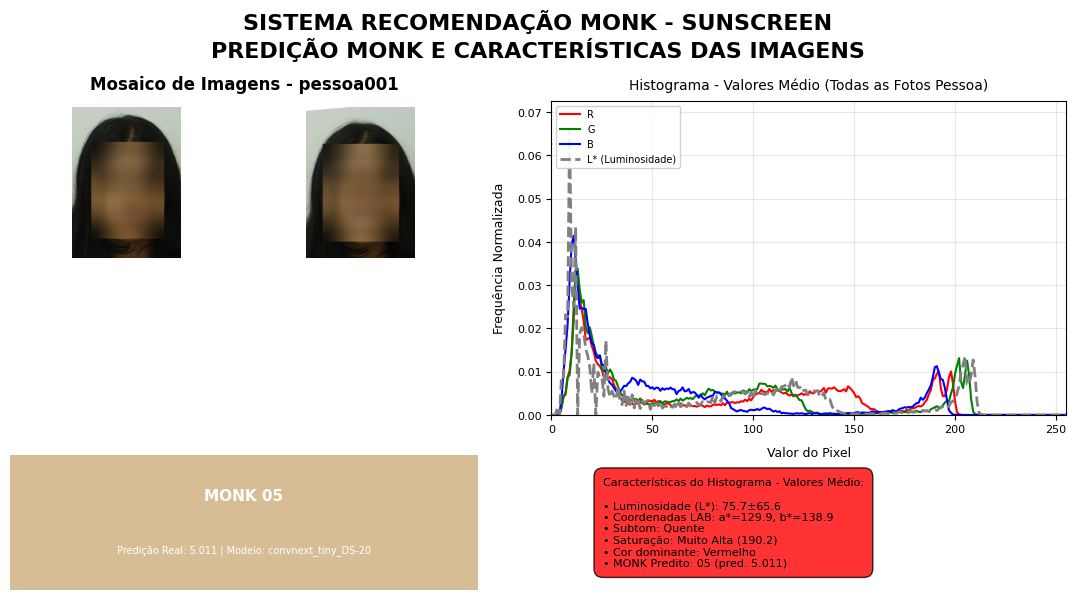

SISTEMA DE FORMULAÇÃO DE PROTETOR SOLAR PERSONALIZADO
INICIANDO CÁLCULO DA FORMULAÇÃO
MONK PREDITO: 5
CARACTERÍSTICAS RECEBIDAS:
  L_mean: 75.69734534438776
  L_std: 65.6072038987487
  a_mean: 129.94060905612244
  b_mean: 138.85307716836735
  subtone: Quente
  saturation_level: Muito Alta
  saturation: 190.17028926990835
  dominant_color: Vermelho
  maior_mst: 5
  maior_pred: 5.010986328125

BASE MONK 5: [1.487, 0.526, 1.269, 0.897, 0.821]
EQUAÇÃO DE CÁLCULO DOS AJUSTES:

1. SUBTOM 'Quente':

2. SATURAÇÃO 190.2 (Muito Alta):

3. LUMINOSIDADE L*=75.7±65.6:

4. COR DOMINANTE 'Vermelho':
AJUSTES FINAIS CALCULADOS:
   Amarelo: +0.00
   Vermelho: +0.00
   Azul: +0.00
   Branco: +0.00
   Preto: +0.00

VALORES APÓS AJUSTES: {'amarelo': 1.487, 'vermelho': 0.526, 'azul': 1.269, 'branco': 0.897, 'preto': 0.821}

GERANDO GRÁFICOS DE ANÁLISE...


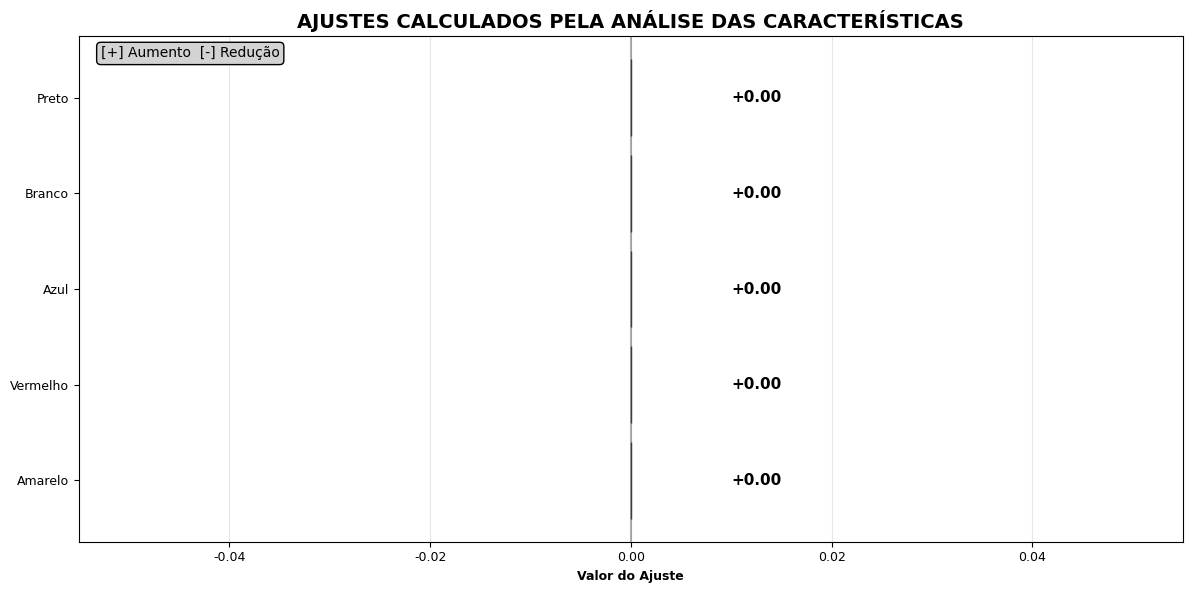

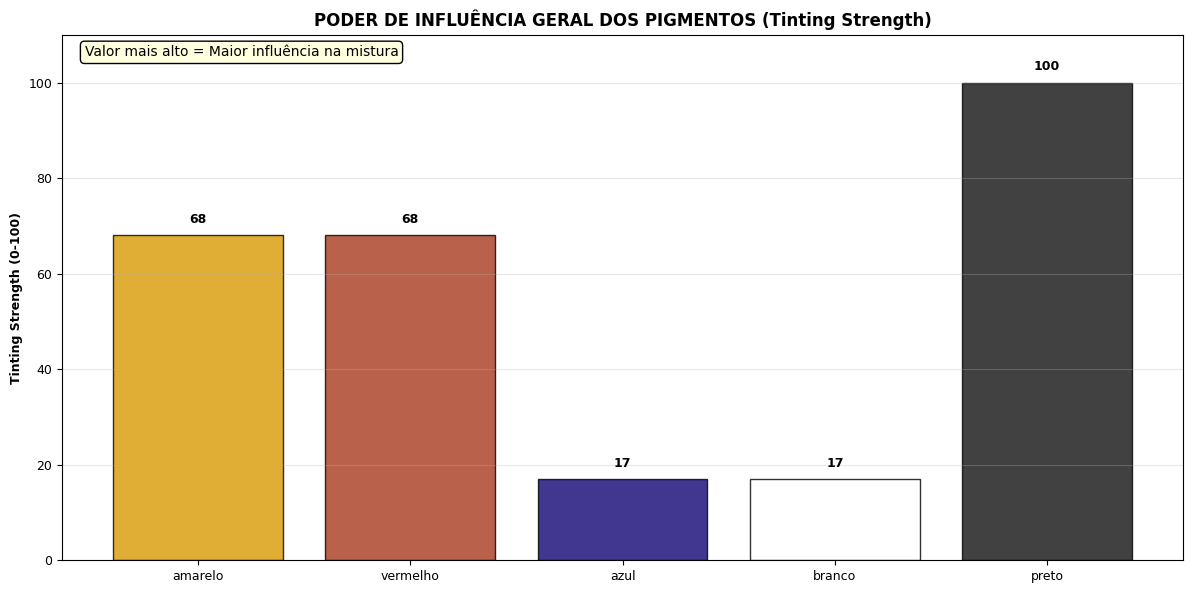

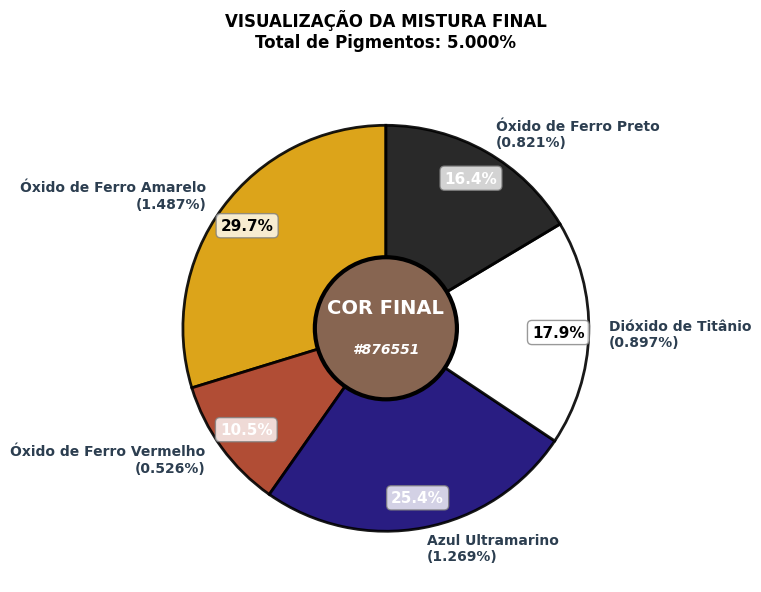


FORMULAÇÃO FINAL:
┌─────────────────────────┬────────────────────┬─────────────────────────────┬───────────┐
│ Pigmento                │ Fórmula            │ INCI                        │ Proporção │
├─────────────────────────┼────────────────────┼─────────────────────────────┼───────────┤
│ Óxido de Ferro Amarelo  │ FeO(OH)·H₂O        │ CI 77492 (Iron Oxides)      │    1.487% │
│ Óxido de Ferro Vermelho │ Fe₂O₃              │ CI 77491 (Iron Oxides)      │    0.526% │
│ Azul Ultramarino        │ Na₆₋₈Al₆Si₆O₂₄S₂₋₄ │ CI 77007 (Ultramarines)     │    1.269% │
│ Dióxido de Titânio      │ TiO₂               │ CI 77891 (Titanium Dioxide) │    0.897% │
│ Óxido de Ferro Preto    │ FeO·Fe₂O₃          │ CI 77499 (Iron Oxides)      │    0.821% │
├─────────────────────────┼────────────────────┼─────────────────────────────┼───────────┤
│ TOTAL                   │                    │                             │    5.000% │
└─────────────────────────┴────────────────────┴───────────────────────

In [30]:
# =============================================================================
# FUNÇÃO PRINCIPAL DE ANÁLISE VISUAL (ATUALIZADA PARA PDF)
# =============================================================================

TESTE_1_PERSON = True

# Utility para salvar figuras no PdfPages suprimindo UserWarning
def save_figure_safe(fig, pdf_pages):
    import warnings
    if pdf_pages is None or fig is None:
        return
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        try:
            pdf_pages.savefig(fig)
        except Exception as e:
            print(f"Erro ao salvar figura no PDF: {e}")

# def criar_pagina_titulo(pessoa_nome=None):
#     """Cria página de título para o PDF com header (título + data) acima do título principal."""
#     fig = plt.figure(figsize=(11, 8.5))
#     fig.patch.set_facecolor('white')

#     # Header no topo com título curto e data (ex.: RELATÓRIO ...  Gerado em: 08/11/2025 02:05)
#     header_text = "RELATÓRIO DE FORMULAÇÃO  PROTETOR SOLAR PERSONALIZADO"
#     data_atual = datetime.datetime.now().strftime("%d/%m/%Y %H:%M")
#     header_full = f"{header_text}  Gerado em: {data_atual}"
#     plt.figtext(0.5, 0.96, header_full, ha='center', va='center', fontsize=10, fontweight='bold')

#     # Título principal abaixo do header
#     plt.figtext(0.5, 0.82, 'RELATÓRIO DE FORMULAÇÃO\nPROTETOR SOLAR PERSONALIZADO',
#                 ha='center', va='center', fontsize=20, fontweight='bold')

#     caracteristicas = formulacao.get('caracteristicas', {})

#     if pessoa_nome:
#         plt.figtext(0.5, 0.70, f'Paciente: {pessoa_nome}',
#                     ha='center', va='center', fontsize=14, fontweight='bold')

#     # info_text = (
#     #     f"Nível Monk: {formulacao.get('monk')}\n"
#     #     f"Subtom: {caracteristicas.get('subtom', '')}\n"
#     #     f"Saturação: {caracteristicas.get('saturation', 0):.1f} ({caracteristicas.get('saturation_level','')})\n"
#     #     f"Luminosidade: {caracteristicas.get('L_mean',0):.1f}±{caracteristicas.get('L_std',0):.1f}\n"
#     #     f"Cor Dominante: {caracteristicas.get('dominant_color','')}\n"
#     #     f"Total de Pigmentos: {formulacao.get('total_pigmentos',0):.3f}%"
#     # )

#     # # Informações resumidas centralizadas abaixo do título (sem caixa de destaque grande)
#     # plt.figtext(0.5, 0.48, info_text, ha='center', va='center', fontsize=11)

#     plt.axis('off')
#     return fig

def gerar_subplot_pessoa(df, pessoa_nome, col_model='convnext_tiny_DS-20', texto_farmaceutico=None,
                         save_pdf=False, pdf_pages=None, mostrar_graficos=True):
    """
    Gera painel 1x2 com subgrids usando um único GridSpec principal
    """
    # Filtra
    df_pessoa = df[df['Pessoa_Folder'] == pessoa_nome]
    if df_pessoa.empty:
        print(f"Nenhuma entrada encontrada para {pessoa_nome}")
        return

    # amostras para mosaico (máximo 4)
    amostras = df_pessoa.sample(min(4, len(df_pessoa)), random_state=42)

    # ENCONTRA A MAIOR PREDIÇÃO ENTRE TODAS AS FOTOS DA PESSOA
    maior_pred = df_pessoa[col_model].max()
    maior_mst = transform_prediction_to_monk_int(maior_pred)

    # Cria figura principal
    fig = plt.figure(figsize=(12, 6.5))

    # GRIDSPEC PRINCIPAL ÚNICO - Controla todo o layout
    gs_principal = fig.add_gridspec(
        3, 2,
        height_ratios=[0.4, 3.5, 1.5],
        width_ratios=[1, 1.1],
        hspace=0.25,
        wspace=0.15,
        top=0.95,
        bottom=0.08,
        left=0.07,
        right=0.95
    )

    # TÍTULOS (linha 0, ambas colunas)
    ax_titulo_principal = fig.add_subplot(gs_principal[0, :])
    ax_titulo_principal.axis('off')
    titulo = "SISTEMA RECOMENDAÇÃO MONK - SUNSCREEN\nPREDIÇÃO MONK E CARACTERÍSTICAS DAS IMAGENS"
    ax_titulo_principal.text(0.5, 0.7, titulo,
                            ha='center', va='center', fontsize=16, fontweight='bold')
    # ax_titulo_principal.text(0.5, 0.725, f"Análise - {pessoa_nome}",
    #                         fontsize=12, weight='bold', ha='center')

    # MOSAICO (linha 1, coluna 0)
    ax_mosaico = fig.add_subplot(gs_principal[1, 0])
    ax_mosaico.set_title(f"Mosaico de Imagens - {pessoa_nome}", fontsize=12, fontweight='bold', pad=8)
    ax_mosaico.axis('off')

    n_imgs = len(amostras)

    # SEMPRE cria 4 posições (2x2)
    for idx in range(4):
        if idx < n_imgs:
            # Processa imagem real
            row = amostras.iloc[idx]
            try:
                img_bgr = cv2.imread(row['file_path'])
                if img_bgr is not None:
                    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

                    # APLICA BLUR SE detect_face_mtcnn ESTIVER DISPONÍVEL
                    img_to_display = img_rgb.copy()
                    if 'detect_face_mtcnn' in globals() and 'apply_blurring_mask' in globals():
                        try:
                            original_pil = Image.fromarray(img_rgb)
                            bbox = detect_face_mtcnn(original_pil)
                            if bbox is not None and len(bbox) == 4:
                                x, y, w, h = tuple(map(int, bbox))
                                img_h, img_w = img_rgb.shape[:2]
                                x = max(0, x); y = max(0, y)
                                w = max(1, min(w, img_w - x))
                                h = max(1, min(h, img_h - y))
                                bbox_norm = (x, y, w, h)

                                img_to_display = apply_blurring_mask(
                                    img_to_display,
                                    bbox_norm,
                                    kernel_size_ratio=0.35,
                                    blur_passes=1
                                )
                                # img_to_display = apply_blurring_mask(img_to_display, bbox_norm)
                        except Exception as e:
                            print(f"  Erro no blur para {row['file_path']}: {e}")

                    img_display = Image.fromarray(img_to_display)
                else:
                    img_display = Image.open(row['file_path']).convert('RGB')
            except Exception as e:
                print(f"Erro ao carregar imagem {row['file_path']}: {e}")
                continue
        else:
            # Cria imagem vazia para posições sem imagem
            img_display = Image.new("RGB", (100, 100), color=(240, 240, 240))

        # Calcula posição da imagem no mosaico - SEMPRE 2x2
        img_width = 0.48
        img_height = 0.48

        # Posições fixas para grid 2x2
        col = idx % 2
        row_pos = idx // 2

        img_x = col * 0.5 + 0.01
        img_y = 0.99 - (row_pos + 1) * 0.5 + 0.01

        ax_img = ax_mosaico.inset_axes([img_x, img_y, img_width, img_height])

        if idx < n_imgs:
            ax_img.imshow(np.array(img_display))
        else:
            # Fundo cinza para posições vazias
            ax_img.set_facecolor('#f0f0f0')

        ax_img.axis('off')

    # HISTOGRAMA (linha 1, coluna 1 - parte superior)
    ax_histograma = fig.add_subplot(gs_principal[1, 1])
    ax_histograma.set_title("Histograma - Valores Médio (Todas as Fotos Pessoa)", fontsize=10, pad=8)

    # CARACTERÍSTICAS (linha 2, coluna 1 - parte inferior)
    ax_caracteristicas = fig.add_subplot(gs_principal[2, 1])
    ax_caracteristicas.axis('off')

    # BARRA MST (linha 2, coluna 0)
    ax_barra = fig.add_subplot(gs_principal[2, 0]) # Define ax_barra here
    ax_barra.axis('off')

    # ------------------ BARRA MST ------------------
    # Obtém imagem MST para a MAIOR predição
    img_mst_path = _find_or_create_mst_image(maior_mst, local_mst_swatches_path)
    print("img_mst_path", img_mst_path, maior_mst, local_mst_swatches_path)

    # Exibe barra MST única
    try:
        # Verifica se as variáveis do modelo existen
        if 'loaded_models' in globals() and 'model_name_full' in globals():
            modelo_info = loaded_models[model_name_full]
            short_name = modelo_info["short_name"]
            modelo_texto = f"Predição Real: {maior_pred:.3f} | Modelo: {short_name}"
        else:
            modelo_texto = f"Predição: {maior_pred:.3f}"

        img_mst = plt.imread(img_mst_path)
        ax_barra.imshow(img_mst, aspect='auto')
        ax_barra.text(0.5, 0.7, f"MONK {maior_mst:02d}",
                   color='white', fontsize=11, ha='center', va='center',
                   weight='bold', transform=ax_barra.transAxes)
        ax_barra.text(0.5, 0.3, modelo_texto,
                   color='white', fontsize=7, ha='center', va='center',
                   transform=ax_barra.transAxes)
        ax_barra.axis('off')
    except Exception as e:
        print(f"Erro ao exibir barra MST única: {e}")
        ax_barra.text(0.5, 0.5, f"MONK {maior_mst:02d}",
                   ha='center', va='center', fontsize=9, transform=ax_barra.transAxes)
        ax_barra.axis('off')

    # ------------------ HISTOGRAMA MÉDIO ------------------
    # carrega TODAS as imagens da pessoa para o histograma médio
    all_faces = []
    target_size_hist = (224, 224)

    for _, row in df_pessoa.iterrows():
        try:
            img_bgr = cv2.imread(row['file_path'])
            if img_bgr is not None:
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                original_pil = Image.fromarray(img_rgb)

                if 'detect_face_mtcnn' in globals():
                    bbox = detect_face_mtcnn(original_pil)
                    if bbox is not None and len(bbox) == 4:
                        # Crop face with margin
                        x, y, w, h = tuple(map(int, bbox))
                        img_w, img_h = original_pil.size
                        margin_ratio = 0.3
                        x1 = max(0, int(x - w * margin_ratio))
                        y1 = max(0, int(y - h * margin_ratio))
                        x2 = min(img_w, int(x + w * (1 + margin_ratio)))
                        y2 = min(img_h, int(y + h * (1 + margin_ratio)))

                        face_pil = original_pil.crop((x1, y1, x2, y2))
                        face_resized = face_pil.resize(target_size_hist)
                        all_faces.append(np.array(face_resized))
                    else:
                        # Usa imagem completa se não detectar face
                        img_resized = original_pil.resize(target_size_hist)
                        all_faces.append(np.array(img_resized))
                else:
                    # Fallback se detector não disponível
                    img_resized = original_pil.resize(target_size_hist)
                    all_faces.append(np.array(img_resized))
        except Exception as e:
            print(f"Erro ao processar imagem {row['file_path']} para histograma: {e}")

    if all_faces:
        # Calculate average image from TODAS as faces
        avg_face = np.mean(np.stack(all_faces, axis=0), axis=0).astype(np.uint8)

        # HISTOGRAMA DIRETO NO SUBPLOT - SEM FUNÇÃO EXTERNA
        # Converte para LAB para obter L*
        avg_face_lab = cv2.cvtColor(avg_face, cv2.COLOR_RGB2LAB)
        L, a, b = cv2.split(avg_face_lab)

        # Cores para os canais
        colors = ['red', 'green', 'blue', 'gray']
        labels = ['R', 'G', 'B', 'L* (Luminosidade)']
        linestyles = ['-', '-', '-', '--']

        # Plota histogramas para cada canal RGB
        for i, channel in enumerate([avg_face[:,:,0], avg_face[:,:,1], avg_face[:,:,2]]):
            hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
            # Normaliza o histograma
            hist = hist / hist.sum()
            ax_histograma.plot(hist, color=colors[i], label=labels[i], linewidth=1.5, linestyle=linestyles[i])

        # Plota histograma para L* (luminosidade) - CINZA TRACEJADO
        hist_L = cv2.calcHist([L], [0], None, [256], [0, 256])
        hist_L = hist_L / hist_L.sum()
        ax_histograma.plot(hist_L, color=colors[3], label=labels[3], linewidth=2.0, linestyle=linestyles[3])

        # AJUSTES ESPECÍFICOS PARA EVITAR SOBREPOSIÇÃO
        ax_histograma.margins(x=0.08, y=0.1)
        ax_histograma.set_xlim(0, 255)
        ax_histograma.set_ylim(bottom=0)

        # Ajusta posicionamento dos labels para evitar sobreposição
        ax_histograma.set_xlabel('Valor do Pixel', fontsize=9, labelpad=8)
        ax_histograma.set_ylabel('Frequência Normalizada', fontsize=9, labelpad=8)

        ax_histograma.tick_params(axis='both', which='major', labelsize=8)
        ax_histograma.legend(loc='upper left', fontsize=7, framealpha=0.9)
        ax_histograma.grid(True, alpha=0.3)

    else:
        ax_histograma.text(0.5, 0.5, "Nenhuma imagem encontrada", ha='center', va='center', fontsize=9)
        ax_histograma.axis('off')

    # ------------------ CARACTERÍSTICAS DO HISTOGRAMA ------------------
    if all_faces:
        avg_face_rgb = np.mean(np.stack(all_faces, axis=0), axis=0).astype(np.uint8)
        avg_face_lab = cv2.cvtColor(avg_face_rgb, cv2.COLOR_RGB2LAB)
        L, a, b = cv2.split(avg_face_lab)
        L_mean, L_std = np.mean(L), np.std(L)
        a_mean, b_mean = np.mean(a), np.mean(b)

        saturation = np.sqrt(a_mean**2 + b_mean**2)

        # Determina subtom
        subtone = "Neutro"
        if saturation > 5:
            if b_mean > 0 and a_mean > 0:
                 subtone = "Quente"
            elif b_mean > 0 and a_mean <= 0:
                 subtone = "Oliva"
            elif b_mean <= 0 and a_mean > 0:
                 subtone = "Frio (Rosado)"
            elif b_mean <= 0 and a_mean <= 0:
                 subtone = "Frio (Azul/Verde)"
            if b_mean > 0 and a_mean > 5:
                 subtone = "Quente"
            elif b_mean < 0 and a_mean > 5:
                 subtone = "Frio (Rosado)"
            elif b_mean > 0 and a_mean < -5:
                 subtone = "Oliva"
            elif abs(a_mean) <= 5 and abs(b_mean) <= 5:
                 subtone = "Neutro"
            elif b_mean > 0 and abs(a_mean) <= 5:
                 subtone = "Quente (Amarelado)"
            elif b_mean < 0 and abs(a_mean) <= 5:
                 subtone = "Frio (Azulado)"

        # Nível de saturação
        if saturation < 10:
            saturation_level = "Muito Baixa"
        elif saturation < 20:
            saturation_level = "Baixa"
        elif saturation < 30:
            saturation_level = "Média"
        elif saturation < 45:
            saturation_level = "Alta"
        else:
            saturation_level = "Muito Alta"

        # Cor dominante
        avg_face_rgb_mean = [np.mean(avg_face_rgb[:, :, i]) for i in range(3)]
        max_channel = np.argmax(avg_face_rgb_mean)
        dominant_colors = {0: "Vermelho", 1: "Verde", 2: "Azul"}
        dominant_color = dominant_colors[max_channel]

        # COR DA CAIXA
        colors_rgb = {"Vermelho": "red", "Verde": "green", "Azul": "blue"}
        box_color = colors_rgb.get(dominant_color, "lightgray")

        # DICIONÁRIO COM TODAS AS VARIÁVEIS
        caracteristicas_dict = {
            "L_mean": L_mean,
            "L_std": L_std,
            "a_mean": a_mean,
            "b_mean": b_mean,
            "subtone": subtone,
            "saturation_level": saturation_level,
            "saturation": saturation,
            "dominant_color": dominant_color,
            "maior_mst": maior_mst,
            "maior_pred": maior_pred
        }

        # TEXTO - ALINHADO À ESQUERDA MAS CAIXA CENTRALIZADA
        stats_text = (
            "Características do Histograma - Valores Médio:\n\n"
            f"• Luminosidade (L*): {caracteristicas_dict['L_mean']:.1f}±{caracteristicas_dict['L_std']:.1f}\n"
            f"• Coordenadas LAB: a*={caracteristicas_dict['a_mean']:.1f}, b*={caracteristicas_dict['b_mean']:.1f}\n"
            f"• Subtom: {caracteristicas_dict['subtone']}\n"
            f"• Saturação: {caracteristicas_dict['saturation_level']} ({caracteristicas_dict['saturation']:.1f})\n"
            f"• Cor dominante: {caracteristicas_dict['dominant_color']}\n"
            f"• MONK Predito: {caracteristicas_dict['maior_mst']:02d} (pred. {caracteristicas_dict['maior_pred']:.3f})"
        )

        # CAIXA CENTRALIZADA COM TEXTO ALINHADO À ESQUERDA
        ax_caracteristicas.clear()
        ax_caracteristicas.axis('off')

        # Ajustar a posição para centralizar melhor
        box_width = 0.85
        box_height = 0.8

        # CENTRALIZAR - ajustar manualmente a posição X
        pos_x = 0.10

        ax_box = ax_caracteristicas.inset_axes([pos_x, (1-box_height)/2, box_width, box_height])
        ax_box.axis('off')

        # Adicionar texto alinhado à esquerda dentro da caixa centralizada
        ax_box.text(0, 0.5, stats_text, fontsize=8, va='center', ha='left',
                   transform=ax_box.transAxes,
                   bbox=dict(boxstyle="round,pad=0.8", facecolor=box_color, alpha=0.8,
                           edgecolor='black', linewidth=1))

    else:
        ax_caracteristicas.text(0.5, 0.5, "Sem dados suficientes\npara análise",
                 ha='center', va='center', fontsize=9)

    # Ajuste final para garantir que tudo caiba
    plt.subplots_adjust(hspace=0.25)

    # Ajuste final para garantir que tudo caiba, tentando tight_layout de forma segura
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        try:
            fig.tight_layout()
        except Exception:
            pass


    # Salvar no PDF se solicitado (não fechar aqui)
    if save_pdf and pdf_pages is not None:
        save_figure_safe(fig, pdf_pages)

    # Salvar no PDF se solicitado (não fechar aqui)
    # if save_pdf and pdf_pages is not None:
    #     with warnings.catch_warnings():
    #         warnings.simplefilter("ignore", UserWarning)
    #         try:
    #             pdf_pages.savefig(fig)
    #         except Exception as e:
    #             print(f"Erro ao salvar PDF: {e}")

    # Mostrar se solicitado (fig ainda está aberta)
    if mostrar_graficos:
        try:
            plt.show()
        except Exception as e:
            print(f"Erro ao exibir figura: {e}")

    # Fechar a figura uma única vez para liberar memória
    try:
        plt.close(fig)
    except Exception:
        pass

    return caracteristicas_dict

# =============================================================================
# FUNÇÃO PARA CRIAR BOTÃO DE DOWNLOAD
# =============================================================================

def criar_botao_download_pdf(pdf_path, texto="📥 Baixar Relatório Completo em PDF"):
    """Cria um botão de download para o PDF e inicia o download automaticamente"""
    with open(pdf_path, "rb") as f:
        pdf_data = f.read()

    pdf_b64 = base64.b64encode(pdf_data).decode()

    html = f'''
    <div style="margin: 20px 0; padding: 15px; background: #f0f8ff; border-radius: 10px; border: 2px solid #4CAF50;">
        <h3 style="color: #2E8B57; margin: 0 0 10px 0;">📊 Relatório Pronto!</h3>
        <p style="margin: 0 0 15px 0;">Download automático iniciado! Se não funcionar, clique no botão abaixo:</p>
        <a href="data:application/pdf;base64,{pdf_b64}" download="{os.path.basename(pdf_path)}" id="autoDownload"
           style="display: inline-block; padding: 12px 24px; background: #4CAF50; color: white;
                  text-decoration: none; border-radius: 5px; font-weight: bold; font-size: 14px;">
           {texto}
        </a>
        <p style="margin: 10px 0 0 0; font-size: 12px; color: #666;">
           Arquivo: {os.path.basename(pdf_path)}
        </p>
    </div>
    <script>
        // Inicia download automático
        setTimeout(function() {{
            var link = document.getElementById('autoDownload');
            if (link) {{
                link.click();
            }}
        }}, 1000);
    </script>
    '''

    display(HTML(html))

# =============================================================================
# FUNÇÃO PRINCIPAL DE EXECUÇÃO (ATUALIZADA)
# =============================================================================

def executar_analise_completa(gerar_pdf=False, nome_pdf=None):
    """
    Função principal para executar a análise completa para todas as pessoas
    """
    col_pessoa = 'Pessoa_Folder'

    if 'new_calibrated_df_with_preds_from_loader' in globals() and new_calibrated_df_with_preds_from_loader is not None and col_pessoa in new_calibrated_df_with_preds_from_loader.columns:
        pessoas_unicas = new_calibrated_df_with_preds_from_loader[col_pessoa].unique()

        # Configurar PDF se solicitado
        pdf_pages = None
        if gerar_pdf:
            if nome_pdf is None:
                timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                nome_pdf = f"analise_monk_completa_{timestamp}.pdf"
            pdf_pages = PdfPages(nome_pdf)
            print(f"📄 Gerando PDF: {nome_pdf}")

        for pessoa_nome in pessoas_unicas:
            print(f"\n--- Gerando subplot para {pessoa_nome} ---")
            try:
                # Gerar análise visual - AGORA SALVA NO PDF TAMBÉM
                pessoa_caracteristicas_dict = gerar_subplot_pessoa(
                    new_calibrated_df_with_preds_from_loader,
                    pessoa_nome,
                    col_model="convnext_tiny_DS-20",
                    save_pdf=gerar_pdf,  # AGORA SALVA NO PDF
                    pdf_pages=pdf_pages,
                    mostrar_graficos=True  # Mostra gráficos normalmente
                )

                # Executar análise completa de fórmula
                analisador = AnalisadorProtetorSolar()

                # Executar análise completa (mostra gráficos E adiciona ao PDF)
                formulacao, cor_resultante = analisador.executar_analise_completa(
                    pessoa_caracteristicas_dict,
                    mostrar_graficos=True,  # Mostra gráficos normalmente
                    gerar_pdf=gerar_pdf,    # Adiciona ao PDF se solicitado
                    pessoa_nome=pessoa_nome,
                    pdf_pages=pdf_pages
                )

            except Exception as e:
                print(f"⚠️ Erro ao gerar subplot para {pessoa_nome}: {e}")

            # Descomentar para teste
            if TESTE_1_PERSON:
              break


        # Fechar PDF se estiver gerando
        if gerar_pdf and pdf_pages is not None:
            pdf_pages.close()
            print(f"✅ PDF salvo com sucesso: {nome_pdf}")

            # Criar botão de download
            criar_botao_download_pdf(nome_pdf)

    else:
        print(f"❌ DataFrame 'new_calibrated_df_with_preds_from_loader' não encontrado ou não contém a coluna '{col_pessoa}'.")

# =============================================================================
# FUNÇÃO PARA EXECUTAR COM PDF
# =============================================================================

def executar_com_pdf():
    """Executa a análise completa e gera PDF com botão de download"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    nome_pdf = f"Report_Monk_sunscreen_review_v02_{timestamp}.pdf"

    executar_analise_completa(gerar_pdf=True, nome_pdf=nome_pdf)

# =============================================================================
# EXECUÇÃO PRINCIPAL
# =============================================================================

if __name__ == "__main__":
    # Para executar normalmente (mostra plots sem PDF)
    # executar_analise_completa(gerar_pdf=False)

    # Para executar e gerar PDF completo com botão de download
    executar_com_pdf()

## DEBUG